In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import os
data_dir = '/home/shiqi_w/code/Project4-power-grid/data'

In [3]:
def integer_to_one_hot(integer, min_val, max_val):
    vector_length = max_val - min_val + 1
    one_hot_vector = [0] * vector_length
    one_hot_vector[integer - min_val] = 1
    return one_hot_vector

def load_dataset_from_files(config):
    data_dir = config['data_dir']
    x_dataset = []
    u_dataset = []
    et_dataset = []
    min_val = 2
    max_val = 7
    for item in os.listdir(data_dir):
        data_file_path = os.path.join(data_dir, item)

        # Check if the file is a directory
        if data_file_path.endswith('.npy') and os.path.exists(data_file_path):
            data_dict = np.load(data_file_path, allow_pickle=True).item()
            x_data = data_dict['signals'][:, :-6]
            if x_data.shape[0]!= 3417 or x_data.shape[1]!= 68:
                print(x_data.shape)
                # print(data_file_path)
            uu_data = data_dict['signals'][:, -6:-4]

            ErrorType = data_dict['ErrorType']
            et = np.array(integer_to_one_hot(ErrorType, min_val, max_val))
            et_data = np.tile(et, (len(x_data), 1))
            # u_data = np.concatenate((uu_data, et_data), axis=1)
            u_data = uu_data

            # Sample the data
            x_data = x_data[::config['sample_step'], :]
            u_data = u_data[::config['sample_step'], :]
            
            x_dataset.append(x_data)
            u_dataset.append(u_data)
            et_dataset.append(et_data)

    return x_dataset, u_dataset, et_dataset

In [4]:
x_dataset, u_dataset, et_dataset = load_dataset_from_files({'data_dir': data_dir, 'sample_step': 10})

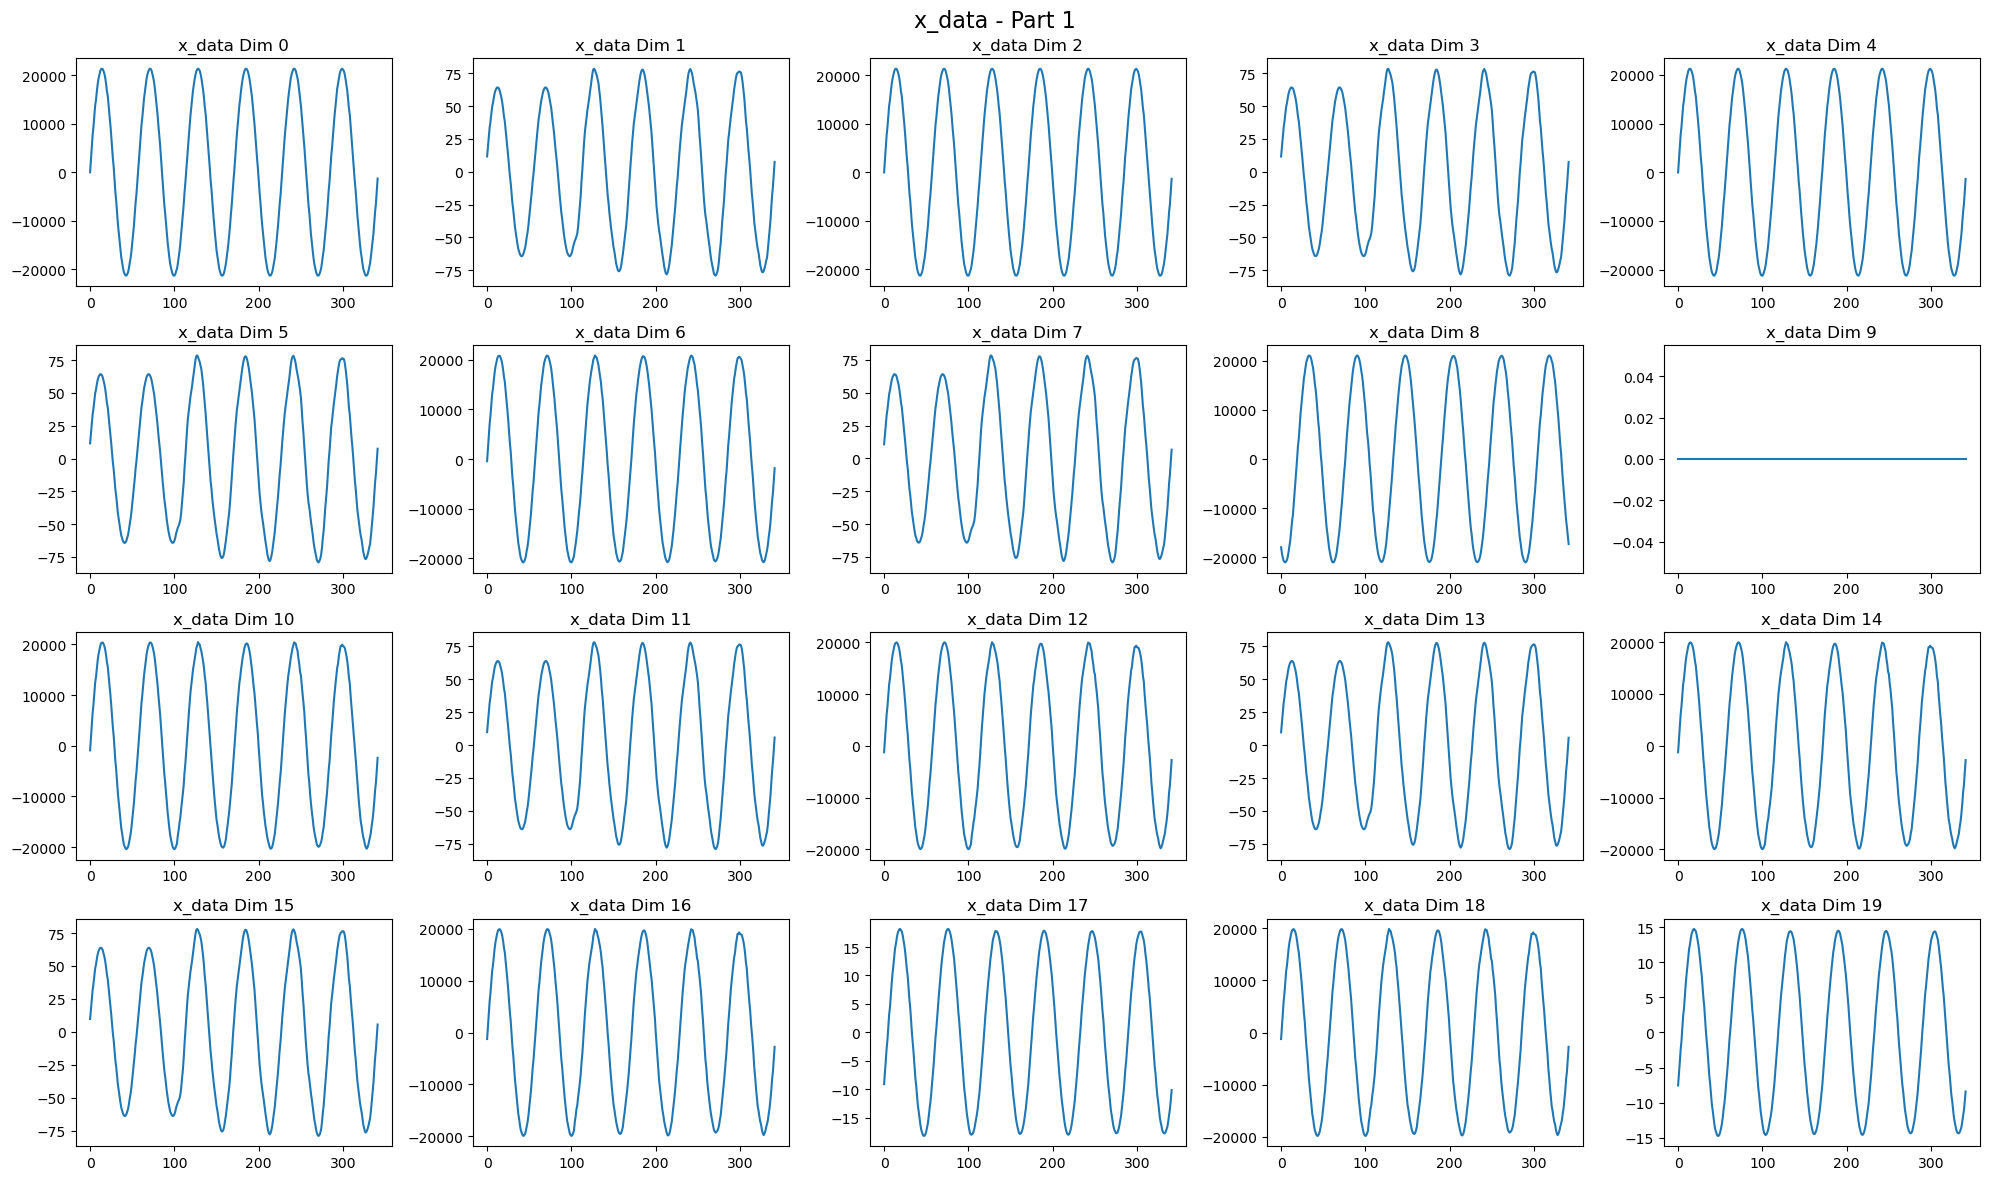

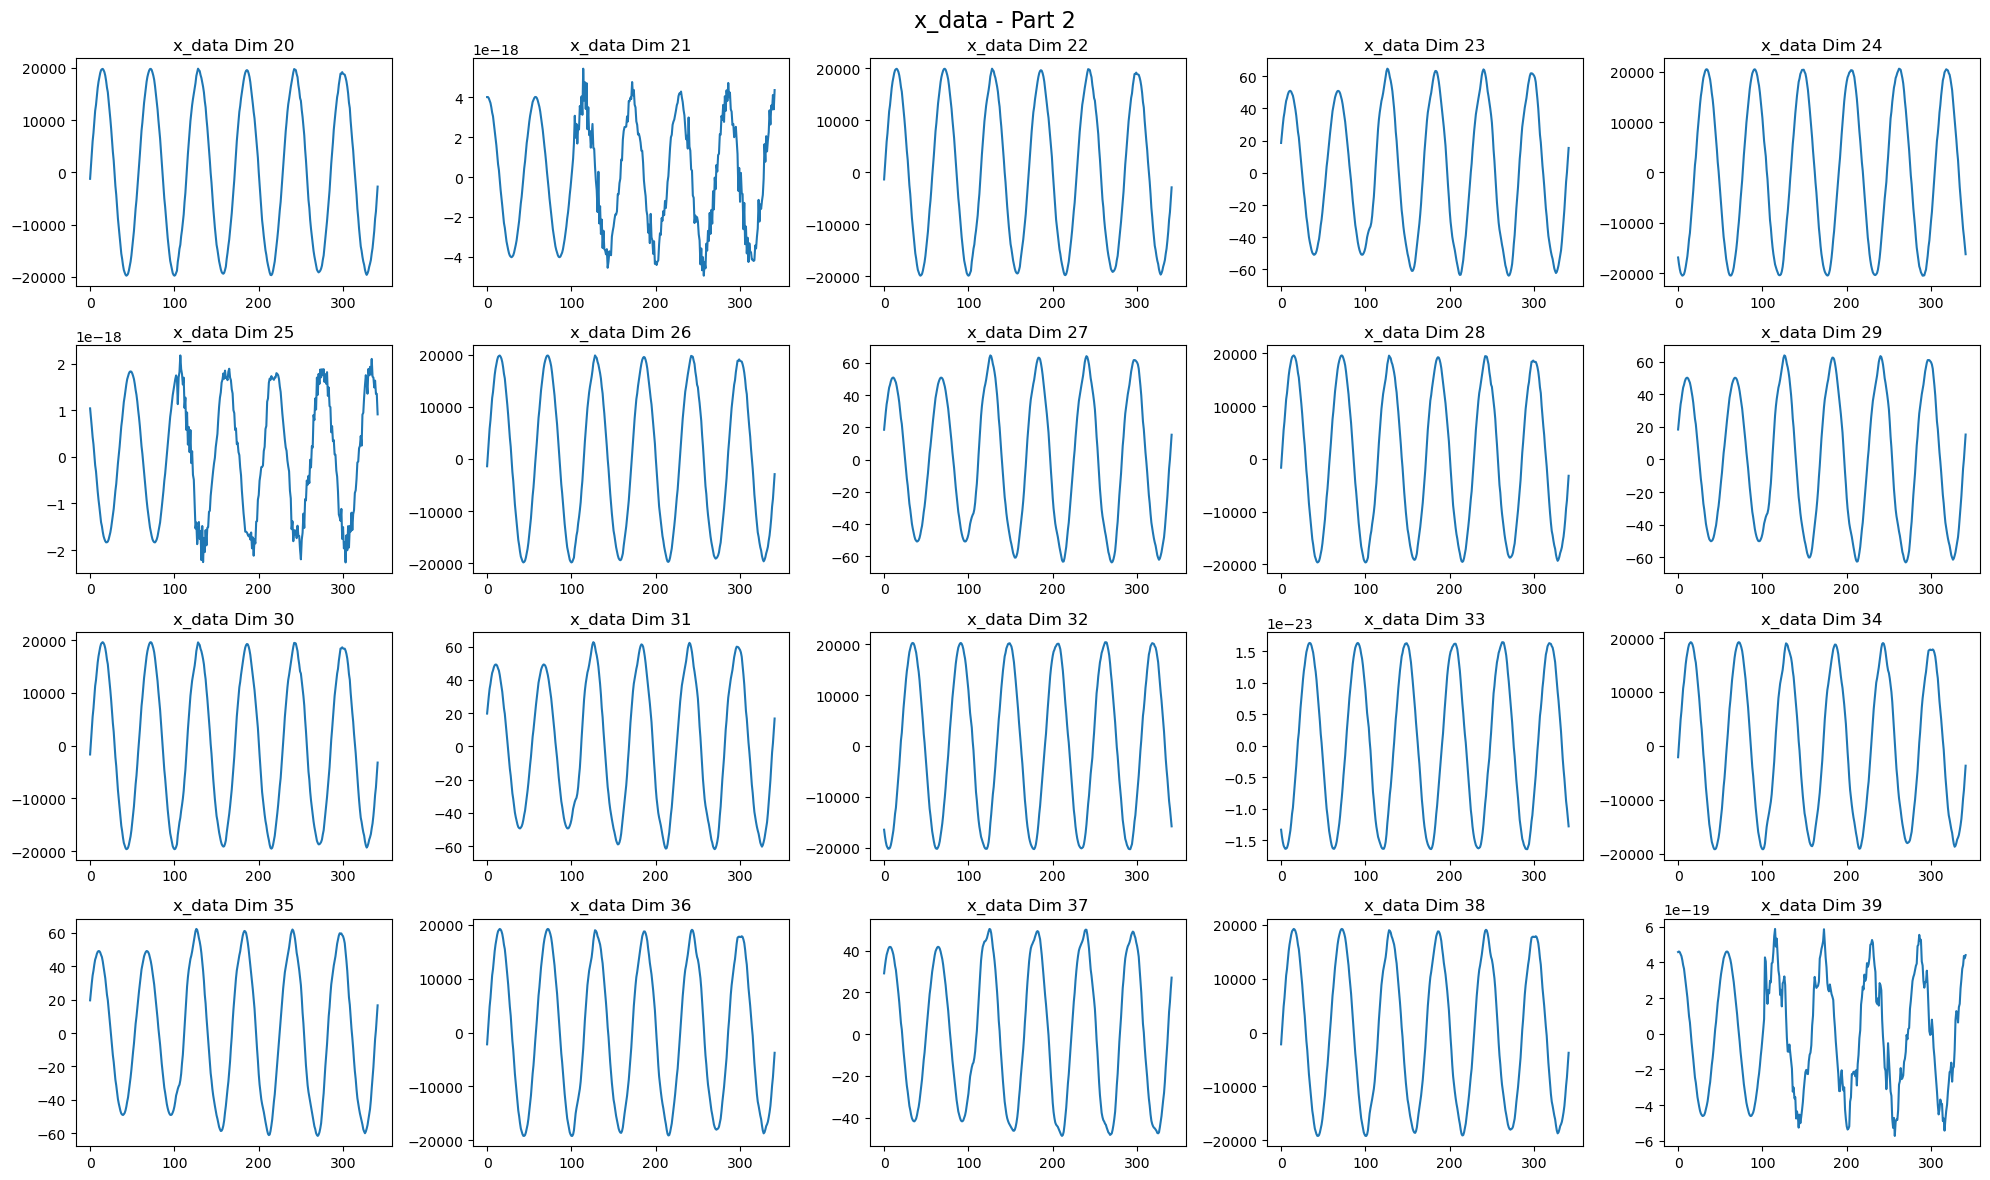

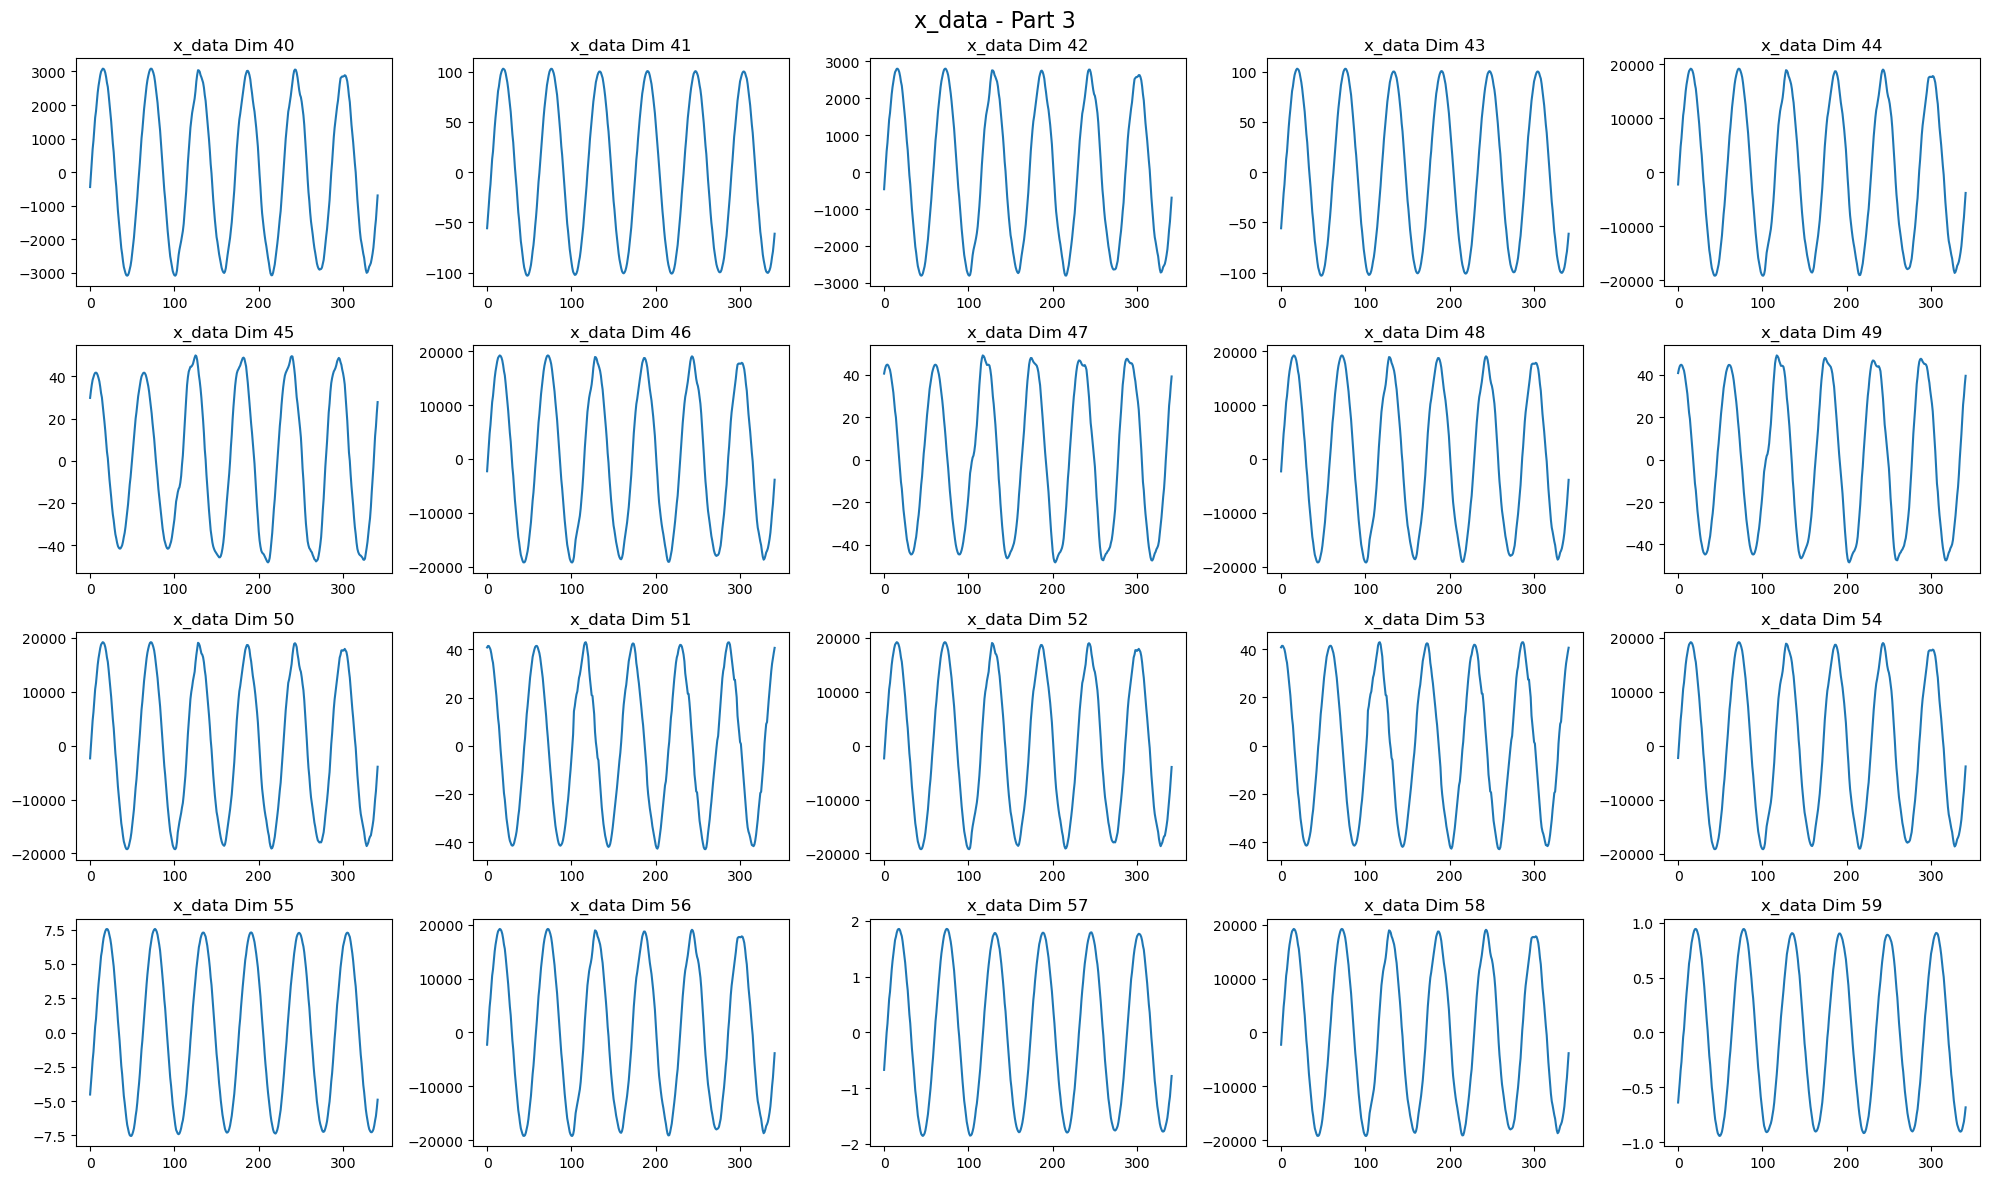

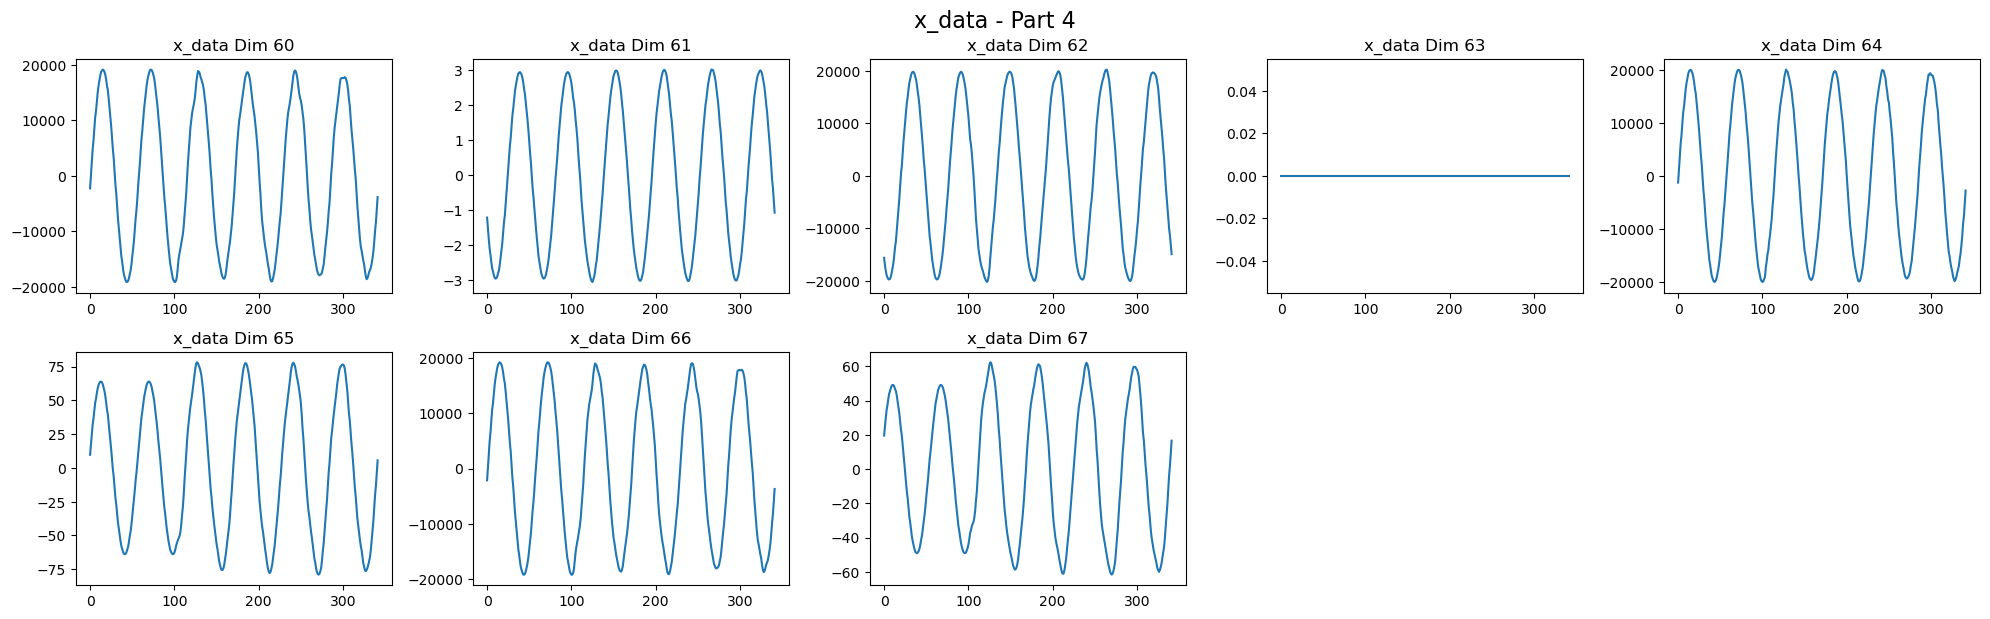

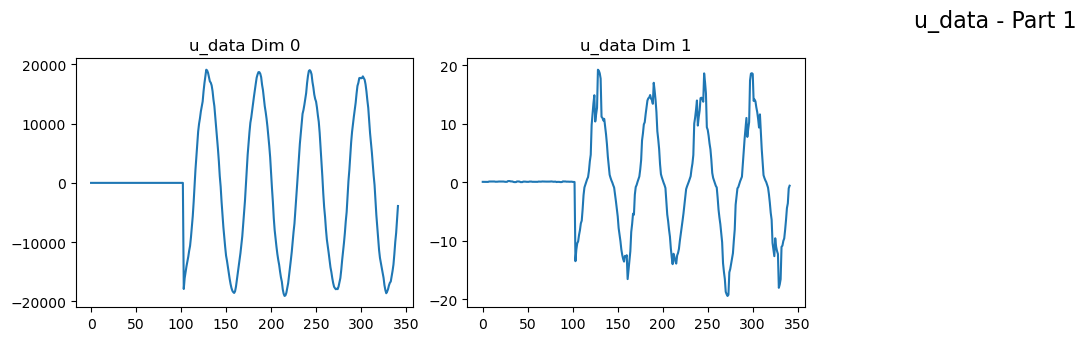

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 选择索引
idx = 10
x_data = x_dataset[idx]
u_data = u_dataset[idx]

# 绘图函数
def plot_data_by_dimension(data, title_prefix):
    num_dims = data.shape[1]
    num_cols = 5
    num_rows = int(np.ceil(num_dims / num_cols))
    fig_count = 0
    figs = []

    for i in range(num_dims):
        if i % (num_cols * 4) == 0:
            if i > 0:
                plt.tight_layout()
                figs.append(plt.gcf())
                plt.show()
            plt.figure(figsize=(20, 12))
            fig_count += 1
            plt.suptitle(f"{title_prefix} - Part {fig_count}", fontsize=16)

        plt.subplot(4, num_cols, (i % (num_cols * 4)) + 1)
        plt.plot(data[:, i])
        plt.title(f"{title_prefix} Dim {i}")
        plt.tight_layout()

    plt.tight_layout()
    figs.append(plt.gcf())
    plt.show()

# 绘制三组数据
plot_data_by_dimension(x_data, "x_data")
plot_data_by_dimension(u_data, "u_data")


In [6]:
from data_preparation import data_preprocessing, data_delete_columns
x_dataset = data_delete_columns(x_dataset)

In [7]:
print(x_dataset[0].shape)

(342, 63)


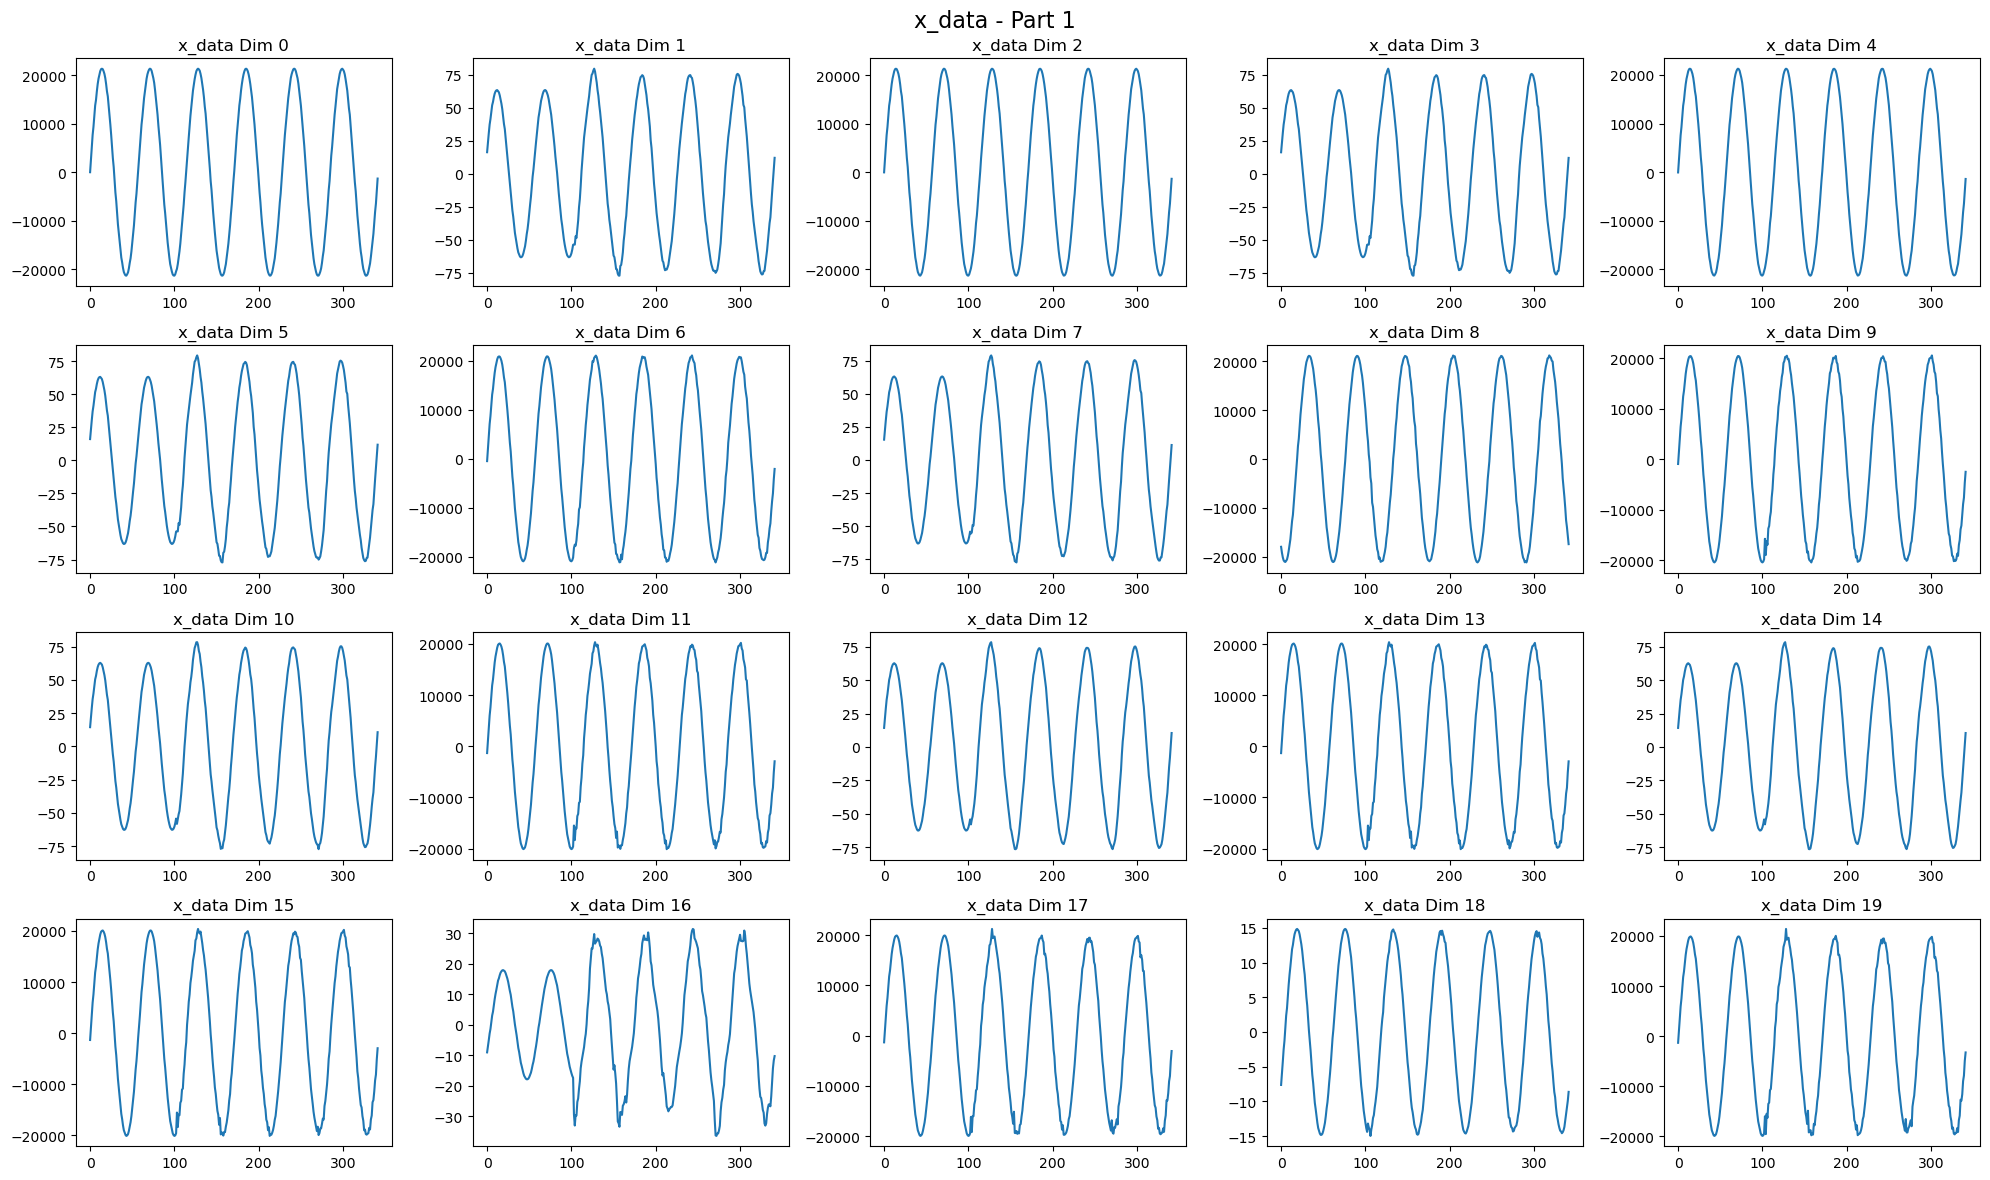

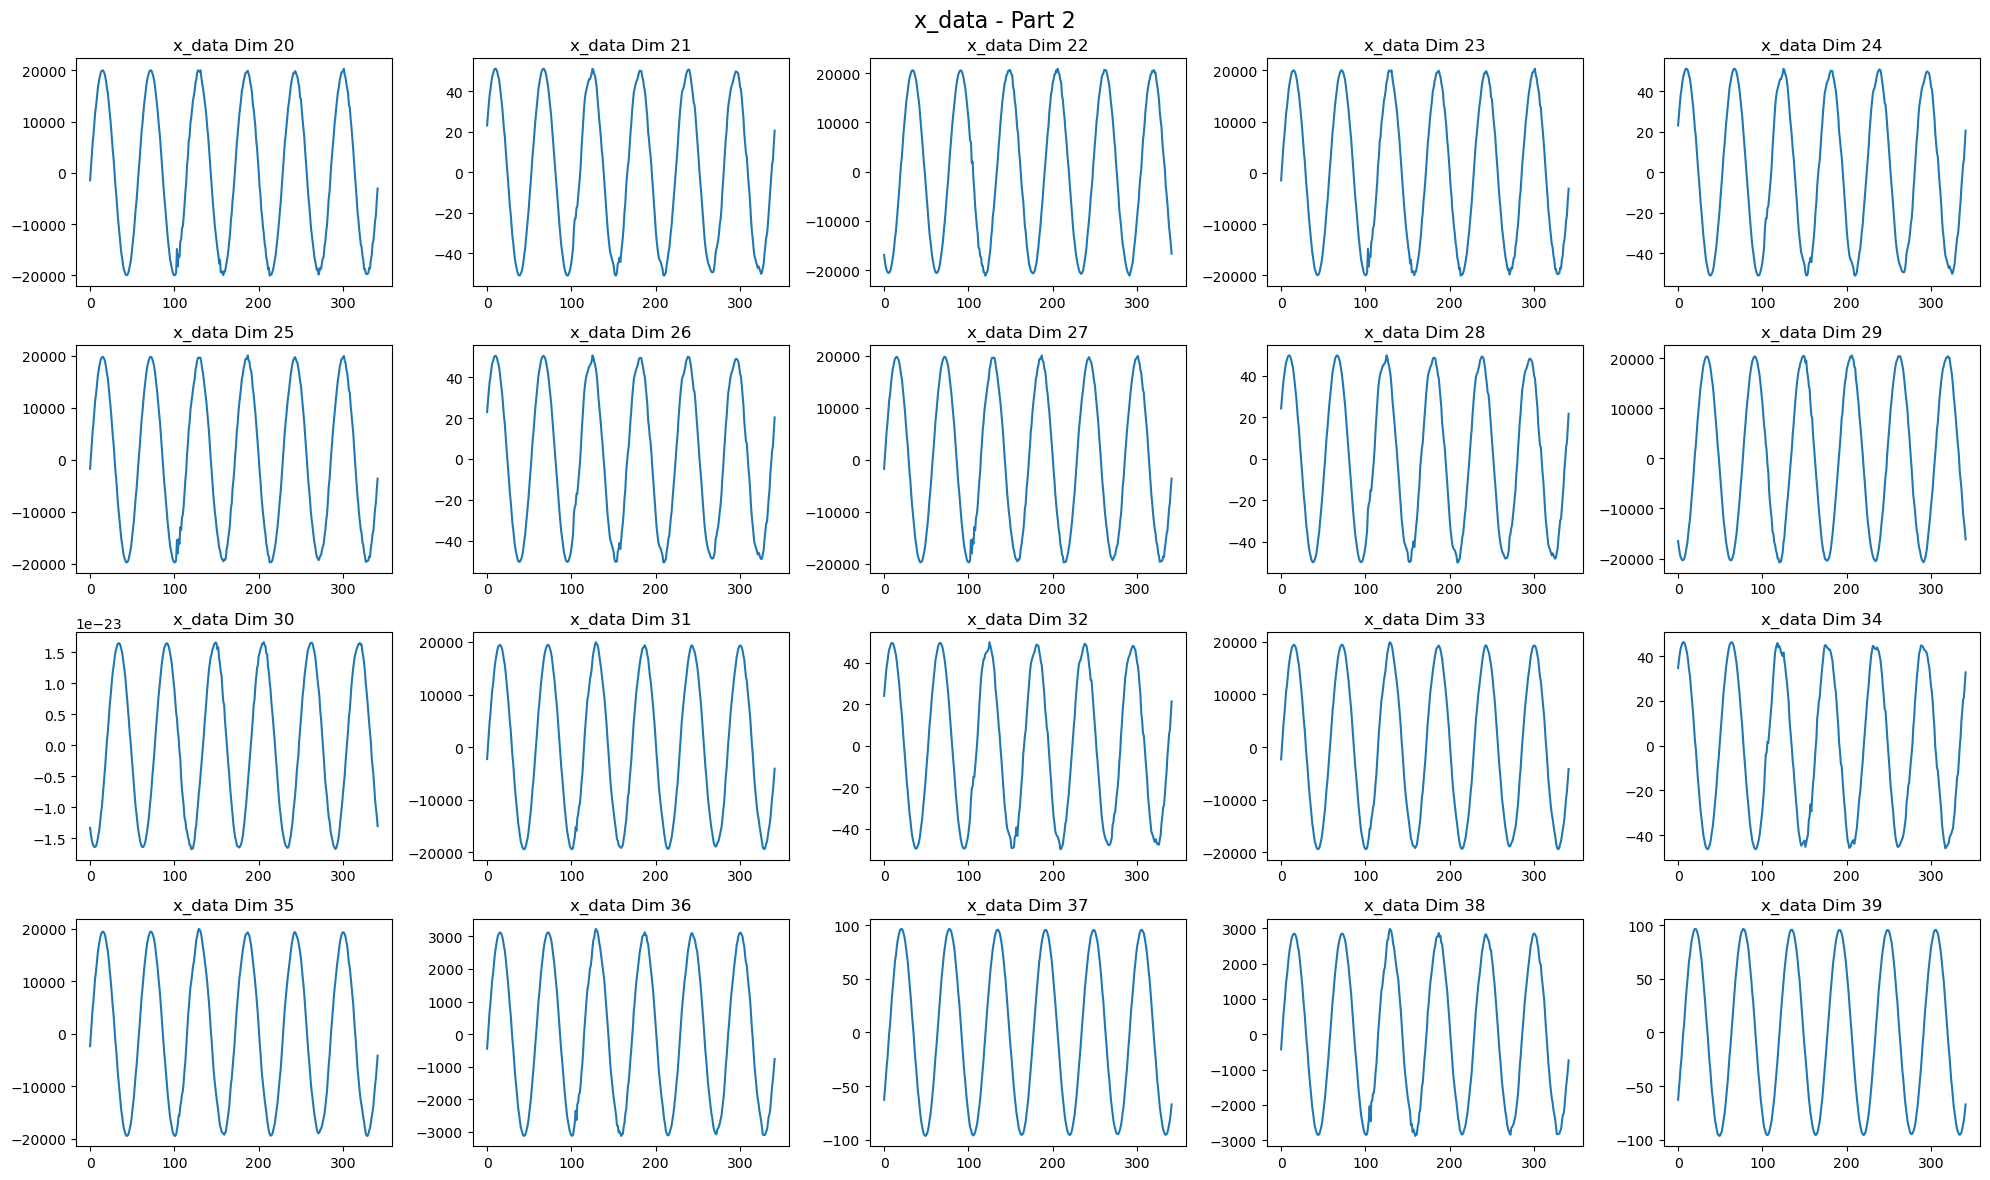

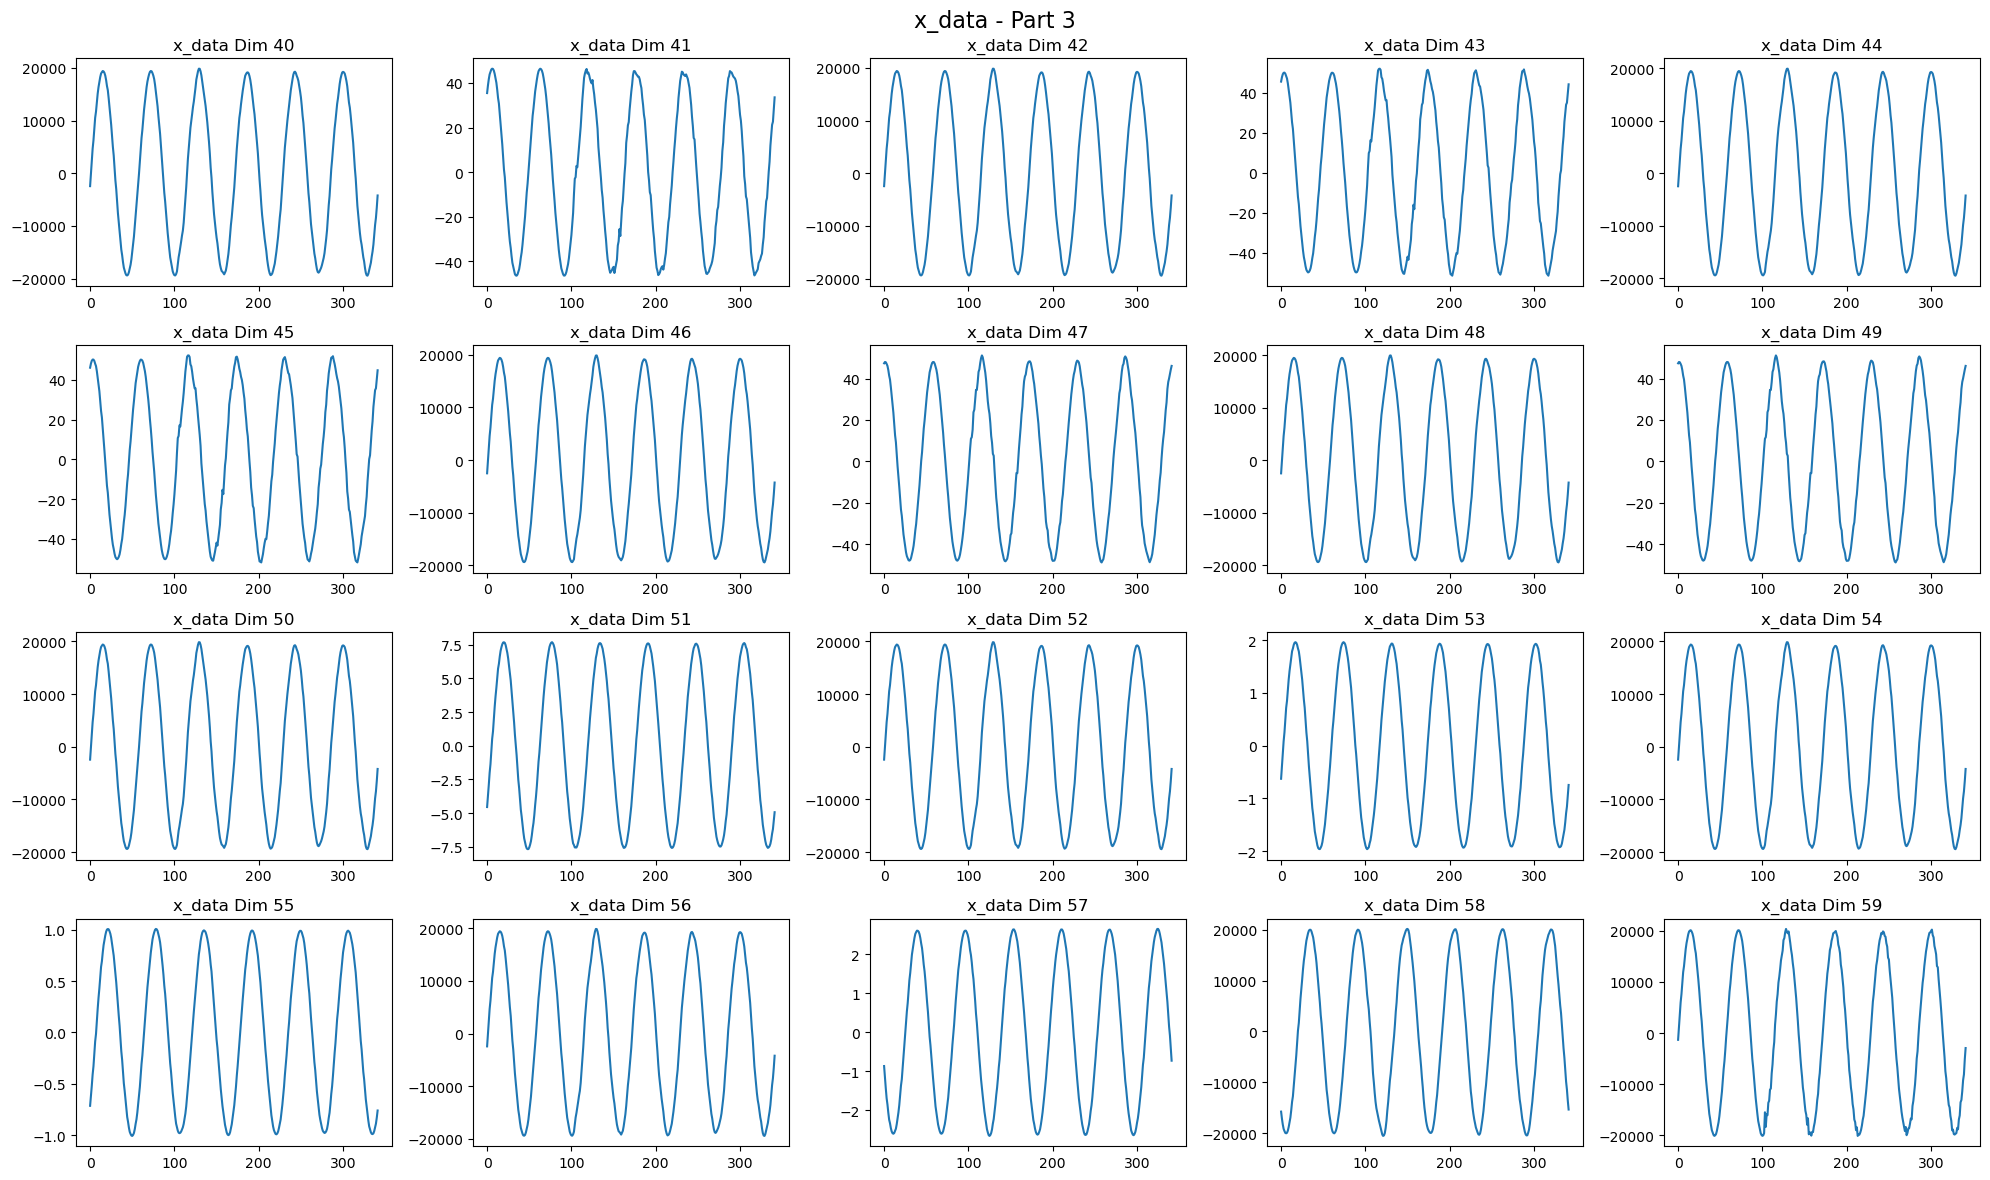

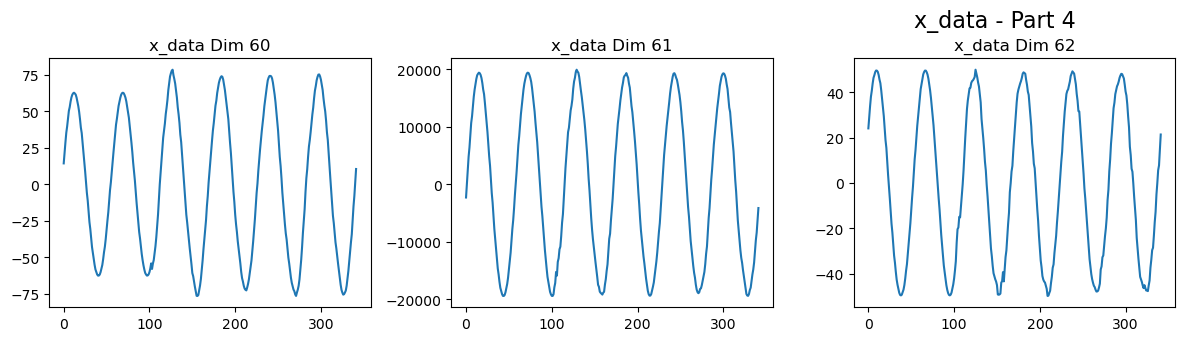

In [8]:
plot_data_by_dimension(x_dataset[0], "x_data")


In [9]:
rescale_pca_layer, x_dataset_new, u_dataset_new = data_preprocessing(x_dataset, u_dataset, 2)


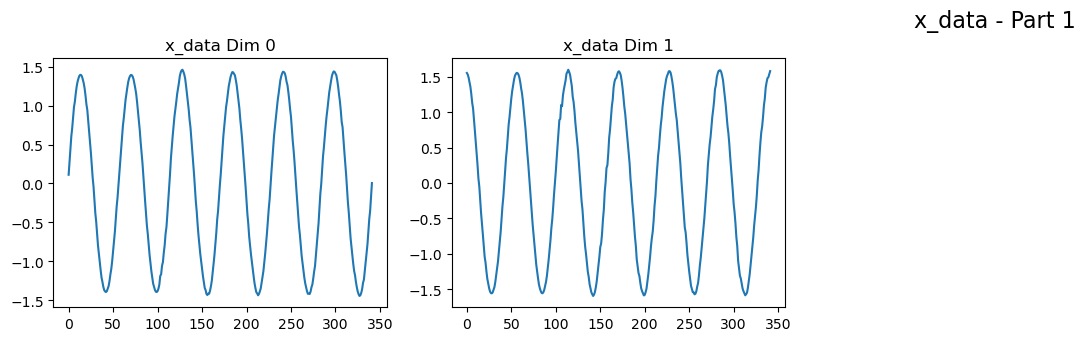

In [10]:
plot_data_by_dimension(x_dataset_new[0], "x_data")


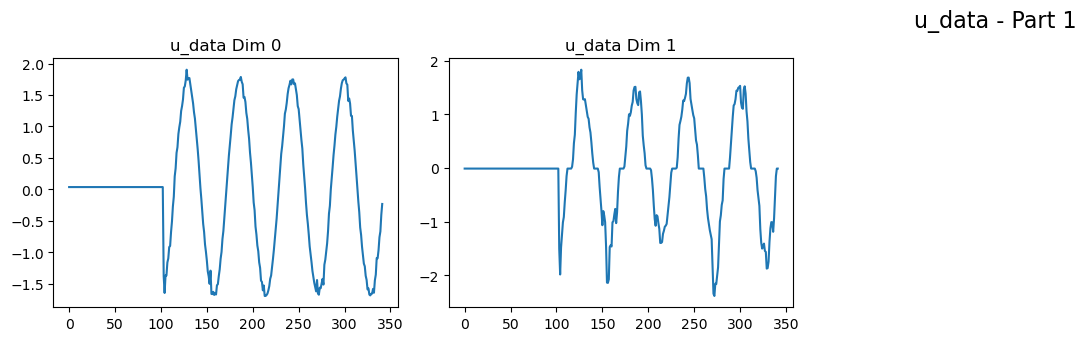

In [11]:
plot_data_by_dimension(u_dataset_new[0], "u_data")


In [12]:
x_data = x_dataset_new[0]
u_data = u_dataset_new[0]
print(x_data.shape)
print(u_data.shape)

(342, 2)
(342, 2)


In [13]:
# import numpy as np

# # 构建 X_t, U_t, X_{t+1}
# X_now = x_data[:100]    # shape (T-1, 2)
# U_now = u_data[:100]    # shape (T-1, 2)
# X_next = x_data[1:101]    # shape (T-1, 2)

# # 拼接 X_t 和 U_t
# XU_now = np.hstack([X_now, U_now])  # shape (T-1, 4)

# # 求解最小二乘解：XU_now @ [K; B] ≈ X_next
# theta, residuals, rank, s = np.linalg.lstsq(XU_now, X_next, rcond=None)
# # theta 的形状是 (4, 2)

# # 拆成 K 和 B
# K_first = theta[:2, :].T  # shape (2, 2)
# B = theta[2:, :].T  # shape (2, 2)

# print("K =", K)
# print("B =", B)


In [14]:
# X_pred = XU_now @ theta  # shape (T-1, 2)
# mse = np.mean((X_pred - X_next)**2)
# print("MSE:", mse)


In [15]:
# eigvals_K, eigvecs_K = np.linalg.eig(K_first)
# eigvals_B, eigvecs_B = np.linalg.eig(B)

# print("K 的特征值：", eigvals_K)
# print("B 的特征值：", eigvals_B)

# mod_K = np.abs(eigvals_K)
# mod_B = np.abs(eigvals_B)

# print("K 的特征值模长：", mod_K)
# print("B 的特征值模长：", mod_B)

In [16]:
import numpy as np

# 构建 X_t, U_t, X_{t+1}
X_now = x_data[:-1]    # shape (T-1, 2)
U_now = u_data[:-1]    # shape (T-1, 2)
X_next = x_data[1:]    # shape (T-1, 2)

# 拼接 X_t 和 U_t
XU_now = np.hstack([X_now, U_now])  # shape (T-1, 4)

# 求解最小二乘解：XU_now @ [K; B] ≈ X_next
theta, residuals, rank, s = np.linalg.lstsq(XU_now, X_next, rcond=None)
# theta 的形状是 (4, 2)

# 拆成 K 和 B
K = theta[:2, :].T  # shape (2, 2)
B = theta[2:, :].T  # shape (2, 2)

print("K =", K)
print("B =", B)

K = [[ 0.99091298  0.10072941]
 [-0.12421269  0.99516349]]
B = [[-0.01379939  0.01973826]
 [-0.01960687  0.0287147 ]]


In [17]:
def predict_trajectory(x_init, u_data, K, B, x_true=None, plot=False, plot_control_contribution=False):
    """
    Predicts a trajectory using the linear dynamics model:
        x_{n+1} = x_n @ K + u_n @ B
    Optionally plots control input contribution at each time step.

    Args:
        x_init (np.ndarray): Initial state vector of shape (n_x,)
        u_data (np.ndarray): Control inputs of shape (T, n_u)
        K (np.ndarray): System dynamics matrix of shape (n_x, n_x)
        B (np.ndarray): Control gain matrix of shape (n_u, n_x)
        x_true (np.ndarray, optional): Ground-truth trajectory of shape (T, n_x)
        plot (bool, optional): Whether to plot predicted vs true trajectory
        plot_control_contribution (bool, optional): Whether to plot u_n @ B contributions

    Returns:
        x_pred (np.ndarray): Predicted trajectory of shape (T, n_x)
        mse (float or None): Mean squared error if x_true is provided
    """
    T = u_data.shape[0]
    n_x = x_init.shape[0]

    x_pred = np.zeros((T, n_x))
    x_pred[0] = x_init

    delta_x_control = np.zeros((T - 1, n_x))  # 存储每一步的 u_n @ B

    for n in range(T - 1):
        delta_x_control[n] = u_data[n] @ B.T
        x_pred[n + 1] = x_pred[n] @ K.T + delta_x_control[n]

    mse = None
    if x_true is not None:
        mse = np.mean((x_pred - x_true) ** 2)
        print("MSE between predicted and true trajectory:", mse)

    if plot and x_true is not None:
        plt.figure(figsize=(10, 4))
        for i in range(n_x):
            plt.plot(x_true[:, i], label=f"x_true[{i}]")
            plt.plot(x_pred[:, i], '--', label=f"x_pred[{i}]")
        plt.title("Predicted vs True Trajectory")
        plt.xlabel("Time Step")
        plt.ylabel("State Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if plot_control_contribution:
        plt.figure(figsize=(10, 4))
        for i in range(n_x):
            plt.plot(delta_x_control[:, i], label=f"Δx_control[{i}] = u @ B[{i}]")
        plt.title("Control Contribution (u @ B) Over Time")
        plt.xlabel("Time Step")
        plt.ylabel("Control-induced Change in State")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return x_pred, mse


In [18]:
# x_pred, mse = predict_trajectory(x_data[0, :], u_data, K_first, B, x_true=x_data, plot=True)

In [19]:
# x_pred, mse = predict_trajectory(x_data[0, :], u_data, K, B, x_true=x_data, plot=True)

In [20]:
# x_pred, mse = predict_trajectory(x_data[0, :], u_data, K, np.zeros((2, 2)), x_true=x_data, plot=True)

In [21]:
# # 已知的 K_first
# K_first = K  # 或你已有的某个固定 K

# # 构造目标项 (T-1, 2)：X_next - X_now @ K_first.T
# delta_x_control = X_next - X_now @ K_first.T

# # 目标是：U_now @ B.T ≈ delta_x_control
# # 所以解最小二乘：U_now @ B.T = delta_x_control
# # => 解 B.T: shape (2, 2)
# B_T, residuals, rank, s = np.linalg.lstsq(U_now, delta_x_control, rcond=None)
# B_next = B_T.T  # 最终 B 仍是 (2, 2)

# print("回归得到的 B =", B_next)

# # 固定的 K_first，回归后的 B
# delta_x_control = U_now @ B_next.T  # shape (T-1, 2)
# x_dyn = X_now @ K_first.T      # shape (T-1, 2)
# X_pred = x_dyn + delta_x_control  # shape (T-1, 2)

# # 计算 MSE
# mse = np.mean((X_pred - X_next) ** 2)
# print("MSE:", mse)



In [22]:
# print(B - B_next)

In [23]:
# x_pred, mse = predict_trajectory(x_data[0, :], u_data, K_first, B_next, x_true=x_data, plot=True)

In [24]:
import numpy as np

def fit_linear_dynamics_full(x_data, u_data):
    """
    Fit linear dynamics matrices K and B from the full trajectory using least squares:
        x_{t+1} ≈ x_t @ K + u_t @ B

    Args:
        x_data (np.ndarray): State trajectory of shape (T, n_x)
        u_data (np.ndarray): Control input trajectory of shape (T, n_u)

    Returns:
        K (np.ndarray): Dynamics matrix of shape (n_x, n_x)
        B (np.ndarray): Control gain matrix of shape (n_u, n_x)
        mse (float): Mean squared prediction error
    """
    assert x_data.shape == u_data.shape, "x_data and u_data must have the same shape"
    T, n_x = x_data.shape
    _, n_u = u_data.shape

    # 构建 X_t, U_t, X_{t+1}
    X_now = x_data[:-1]    # shape (T-1, n_x)
    U_now = u_data[:-1]    # shape (T-1, n_u)
    X_next = x_data[1:]    # shape (T-1, n_x)

    # 拼接 [X_t, U_t]
    XU_now = np.hstack([X_now, U_now])  # shape (T-1, n_x + n_u)

    # 最小二乘拟合：XU_now @ theta ≈ X_next
    theta, residuals, rank, s = np.linalg.lstsq(XU_now, X_next, rcond=None)

    # 拆解出 K 和 B
    K = theta[:n_x, :].T  # shape (n_x, n_x)
    B = theta[n_x:, :].T  # shape (n_x, n_u)

    # 计算预测误差
    X_pred = X_now @ K.T + U_now @ B.T
    mse = np.mean((X_pred - X_next)**2)

    return K, B, mse


In [25]:
def build_time_window_dataset(x_dataset, u_dataset=None, window_size=2, flatten=True):
    """
    Builds a time-windowed dataset from a list of sequences.

    Args:
        x_dataset (list of np.ndarray): Each of shape (T, n_x)
        u_dataset (list of np.ndarray, optional): Each of shape (T, n_u), same length as x_dataset
        window_size (int): Number of time steps to include in the window
        flatten (bool): If True, flatten each window to 1D vector. Else, return 3D window.

    Returns:
        x_windows: list of np.ndarray of shape (T - window_size + 1, window_shape)
        u_windows (optional): same for u if u_dataset is provided
    """
    x_window_list = []
    u_window_list = [] if u_dataset is not None else None

    for i in range(len(x_dataset)):
        x_seq = x_dataset[i]
        T, n_x = x_seq.shape

        x_windows = []
        for t in range(T - window_size + 1):
            window = x_seq[t:t+window_size]
            if flatten:
                window = window.reshape(-1)
            x_windows.append(window)

        x_window_list.append(np.array(x_windows))

        # If u is given
        if u_dataset is not None:
            u_seq = u_dataset[i]
            T_u, n_u = u_seq.shape
            assert T_u == T, "u and x must have same length"

            u_windows = []
            for t in range(T - window_size + 1):
                u_window = u_seq[t:t+window_size]
                if flatten:
                    u_window = u_window.reshape(-1)
                u_windows.append(u_window)
            u_window_list.append(np.array(u_windows))

    if u_dataset is not None:
        return x_window_list, u_window_list
    else:
        return x_window_list


In [26]:
# x_dataset_new = [x_data[10:, :] for x_data in x_dataset_new]
# u_dataset_new = [u_data[10:, :] for u_data in u_dataset_new]
x_dataset_2, u_dataset_2 = build_time_window_dataset(x_dataset_new, u_dataset_new, window_size=1, flatten=True)

In [27]:
from sklearn.model_selection import train_test_split

# 将数据集分成训练集和测试集
x_train, x_test, u_train, u_test, et_train, et_test = train_test_split(
    x_dataset_2, u_dataset_2, et_dataset, test_size=0.2, random_state=42)

print(f"训练集大小: {len(x_train)}")
print(f"测试集大小: {len(x_test)}")

训练集大小: 96
测试集大小: 24


In [28]:
K_list = []
B_list = []

for x_data, u_data in zip(x_train, u_train):
    K, B, mse = fit_linear_dynamics_full(x_data, u_data)
    K_list.append(K)
    B_list.append(B)

In [29]:
print(et_dataset[0][0])

[0 0 1 0 0 0]


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_B_matrices_embedding(B_list_full, et_dataset, method='pca', B_representatives=None,
                              title=None, cmap="tab10", random_state=42):
    """
    Visualize B matrices using PCA or t-SNE. Optionally overlay representative B per class.

    Args:
        B_list_full (list of np.ndarray): All B matrices (e.g., per-sample), shape (N, n_x, n_u)
        et_dataset (list): Each element has a one-hot label at et_data[0]
        method (str): 'pca' or 'tsne'
        B_representatives (list of np.ndarray): Optional, class-level representative B matrices
        title (str): Title of the plot
        cmap (str): Matplotlib colormap name
        random_state (int): Seed for reproducibility
    """
    # Flatten B matrices
    B_vectors = np.array([B.flatten() for B in B_list_full])
    labels = np.array([np.argmax(et_data[0]) for et_data in et_dataset])
    unique_labels = np.unique(labels)

    has_reps = B_representatives is not None
    if has_reps:
        B_rep_vectors = np.array([B.flatten() for B in B_representatives])
        all_vectors = np.vstack([B_vectors, B_rep_vectors])
    else:
        all_vectors = B_vectors

    # Dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
        all_2d = reducer.fit_transform(all_vectors)
        title = title or "PCA of B Matrices"
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=min(30, len(all_vectors)-1),
                       random_state=random_state, init='random')
        all_2d = reducer.fit_transform(all_vectors)
        title = title or "t-SNE of B Matrices"
    else:
        raise ValueError("method must be either 'pca' or 'tsne'")

    B_2d = all_2d[:len(B_vectors)]
    B_rep_2d = all_2d[len(B_vectors):] if has_reps else None

    # Plot full B list
    plt.figure(figsize=(8, 6))
    for class_id in unique_labels:
        idx = labels == class_id
        plt.scatter(B_2d[idx, 0], B_2d[idx, 1],
                    label=f"Class {class_id}", s=50, alpha=0.7)

    # Plot class representative B
    if has_reps:
        for i, (x, y) in enumerate(B_rep_2d):
            plt.scatter(x, y, marker='X', color=plt.get_cmap(cmap)(i),
                        edgecolors='black', s=120, label=f"Class {i} (rep)")

    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.legend(title="Label", loc="best", fontsize=9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


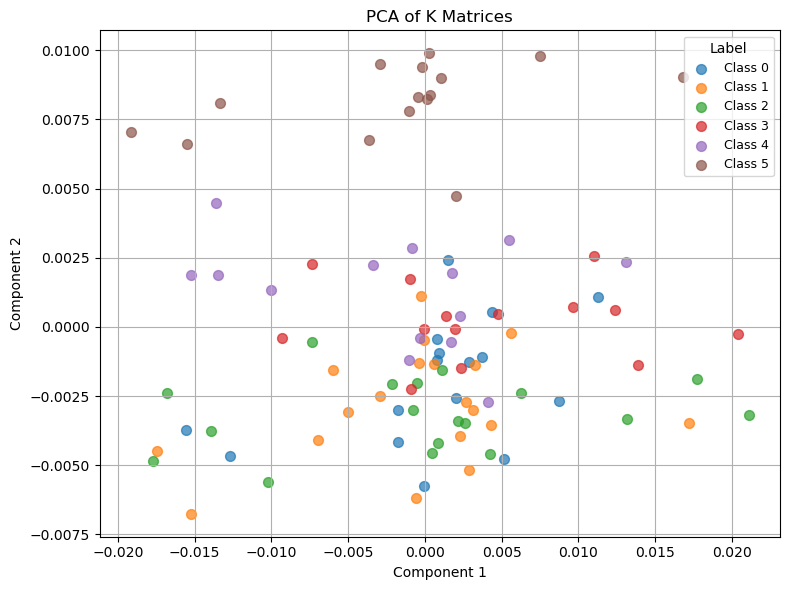

In [31]:
plot_B_matrices_embedding(K_list, et_train, method='pca', title="PCA of K Matrices", cmap="tab10", random_state=42)

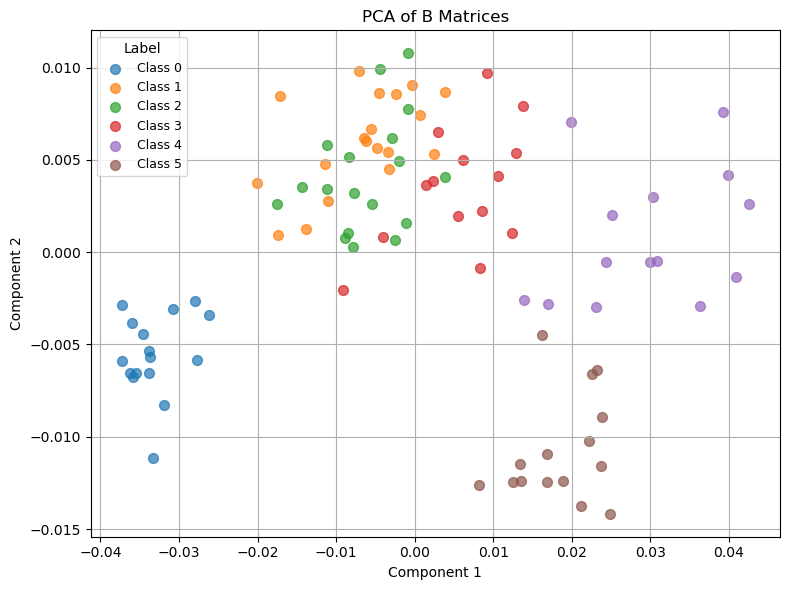

In [32]:
plot_B_matrices_embedding(B_list, et_train, method='pca', title="PCA of B Matrices", cmap="tab10", random_state=42)

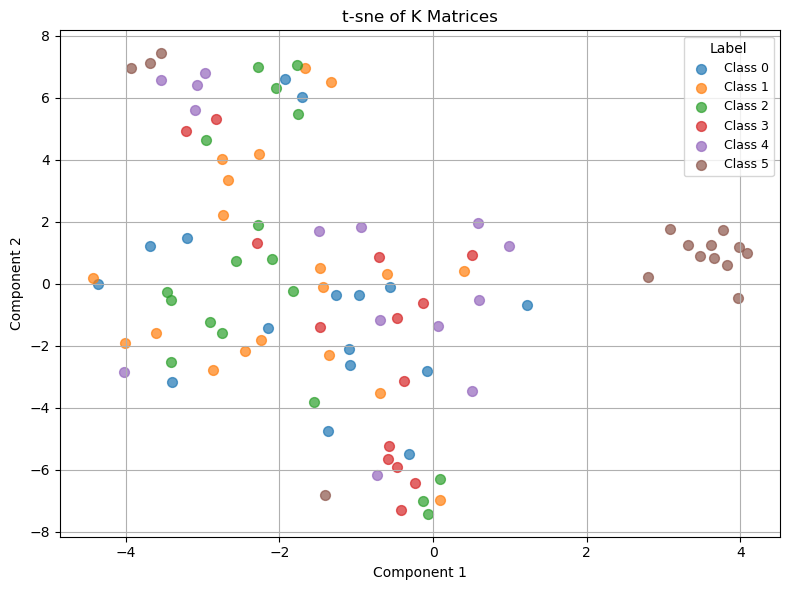

In [33]:
plot_B_matrices_embedding(K_list, et_train, method='tsne', title="t-sne of K Matrices", cmap="tab10", random_state=42)

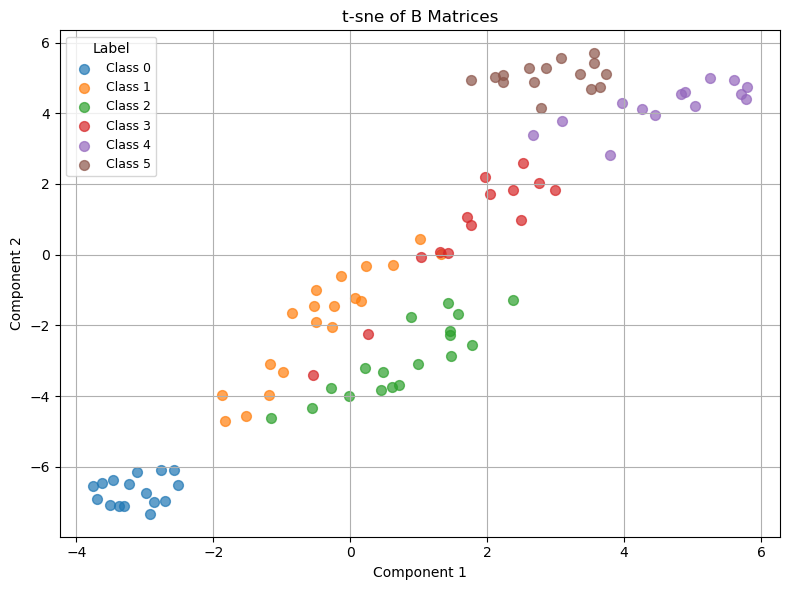

In [34]:
plot_B_matrices_embedding(B_list, et_train, method='tsne', title="t-sne of B Matrices", cmap="tab10", random_state=42)

In [35]:
def compute_K_and_B_per_class(x_dataset, u_dataset, et_dataset, shared_K=True):
    """
    Compute system matrix K (shared or per-class) and B matrix per class.

    Args:
        x_dataset: list of np.ndarray, each (T, n_x)
        u_dataset: list of np.ndarray, each (T, n_u)
        et_dataset: list of metadata, where et_data[0] is one-hot class label
        shared_K (bool): If True, estimate one global K; else estimate K_i for each class.

    Returns:
        K_list: list of np.ndarray (n_x, n_x), one per class
        B_list: list of np.ndarray (n_x, n_u), one per class
        B_mse_list: list of float, MSE per class
    """
    num_classes = len(et_dataset[0][0])
    class_data = {i: {'X': [], 'Y': [], 'U': []} for i in range(num_classes)}

    for x, u, et in zip(x_dataset, u_dataset, et_dataset):
        class_idx = int(np.argmax(et[0]))
        class_data[class_idx]['X'].append(x[:-1])
        class_data[class_idx]['Y'].append(x[1:])
        class_data[class_idx]['U'].append(u[:-1])

    if shared_K:
        # Compute global K
        X_all = []
        Y_all = []
        for i in range(num_classes):
            X_all.append(np.vstack(class_data[i]['X']))
            Y_all.append(np.vstack(class_data[i]['Y']))
        X_cat = np.vstack(X_all)
        Y_cat = np.vstack(Y_all)
        K_global, _, _, _ = np.linalg.lstsq(X_cat, Y_cat, rcond=None)
        K_list = [K_global] * num_classes  # replicate for each class
    else:
        K_list = []  # will fill per class

    B_list = []
    B_mse_list = []

    for i in range(num_classes):
        X_i = np.vstack(class_data[i]['X'])
        Y_i = np.vstack(class_data[i]['Y'])
        U_i = np.vstack(class_data[i]['U'])

        if shared_K:
            K_i = K_list[i]
        else:
            K_i, _, _, _ = np.linalg.lstsq(X_i, Y_i, rcond=None)
            K_list.append(K_i)

        delta_Y = Y_i - X_i @ K_i
        B_T, _, _, _ = np.linalg.lstsq(U_i, delta_Y, rcond=None)
        B = B_T.T

        Y_pred = X_i @ K_i + U_i @ B.T
        mse = np.mean((Y_i - Y_pred) ** 2)

        B_list.append(B)
        B_mse_list.append(mse)

    return K_list, B_list, B_mse_list



In [36]:
K_list_class, B_list_class, B_mse_list = compute_K_and_B_per_class(x_train, u_train, et_train, shared_K=True)

print("K =", K_list_class)
print("B_list contains", len(B_list), "class-specific B matrices.")
print("B_mse_list =", B_mse_list)


K = [array([[ 0.99391096, -0.11026371],
       [ 0.10957229,  0.99353028]]), array([[ 0.99391096, -0.11026371],
       [ 0.10957229,  0.99353028]]), array([[ 0.99391096, -0.11026371],
       [ 0.10957229,  0.99353028]]), array([[ 0.99391096, -0.11026371],
       [ 0.10957229,  0.99353028]]), array([[ 0.99391096, -0.11026371],
       [ 0.10957229,  0.99353028]]), array([[ 0.99391096, -0.11026371],
       [ 0.10957229,  0.99353028]])]
B_list contains 96 class-specific B matrices.
B_mse_list = [np.float64(0.0004097353170023027), np.float64(0.00048603418562475134), np.float64(0.0005344670549225353), np.float64(0.0005480744161272286), np.float64(0.00044533643308330057), np.float64(0.00042298033008516546)]


In [37]:
print(K_list_class[0])
print(K_list[1])
print(K)

[[ 0.99391096 -0.11026371]
 [ 0.10957229  0.99353028]]
[[ 0.99780727  0.11273246]
 [-0.1107146   1.00089082]]
[[ 0.99693255  0.10996706]
 [-0.11242524  0.9900281 ]]


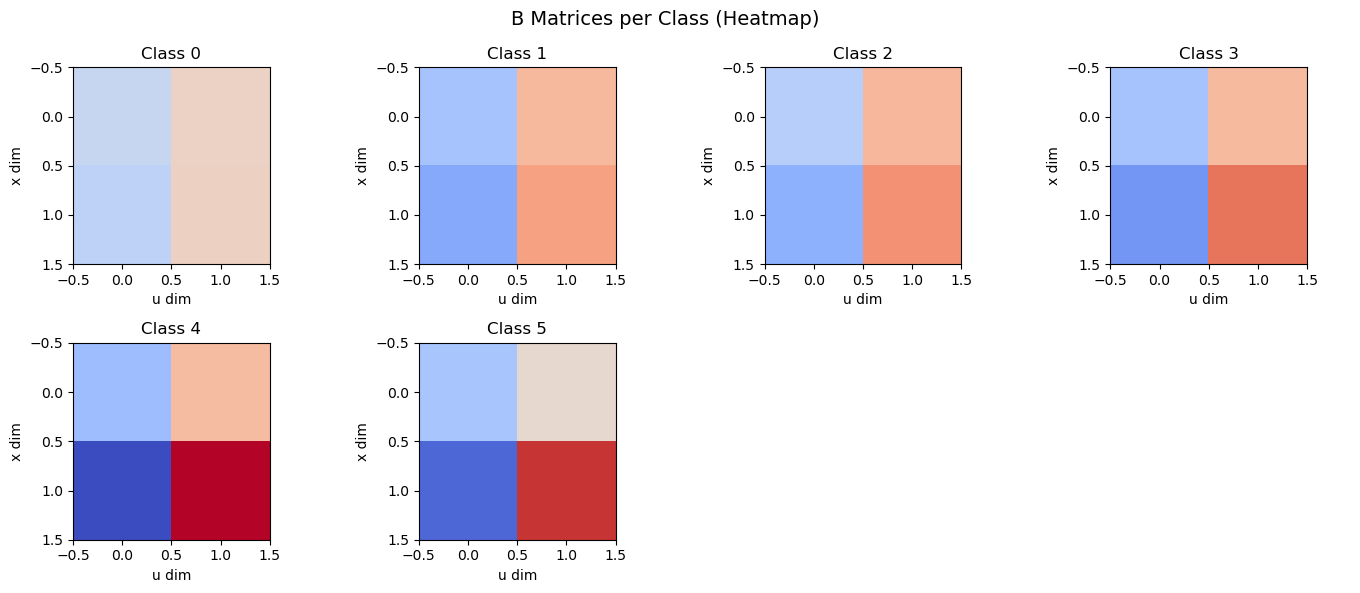

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plot_B_list_heatmaps(B_list, title="B Matrices per Class (Heatmap)"):
    """
    Plot each B matrix in B_list as a heatmap, using shared color scale.

    Args:
        B_list (list of np.ndarray): Each B is shape (n_x, n_u)
        title (str): Overall title
    """
    num_classes = len(B_list)
    n_x, n_u = B_list[0].shape

    # Stack all Bs to get global min/max for color scale
    B_stack = np.stack(B_list)  # shape (num_classes, n_x, n_u)
    vmin = np.min(B_stack)
    vmax = np.max(B_stack)

    # Plot settings
    ncols = min(4, num_classes)
    nrows = int(np.ceil(num_classes / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5 * ncols, 3 * nrows))

    if nrows == 1:
        axes = np.expand_dims(axes, 0)
    axes = axes.flatten()

    for i, B in enumerate(B_list):
        ax = axes[i]
        im = ax.imshow(B, cmap='coolwarm', vmin=vmin, vmax=vmax)
        ax.set_title(f"Class {i}")
        ax.set_xlabel("u dim")
        ax.set_ylabel("x dim")

    # Hide unused subplots
    for j in range(len(B_list), len(axes)):
        axes[j].axis("off")

    # Shared colorbar
    fig.suptitle(title, fontsize=14)
    # cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.20)
    # cbar.set_label("B Value", fontsize=10)
    plt.tight_layout()
    plt.show()

plot_B_list_heatmaps(B_list_class, title="B Matrices per Class (Heatmap)")

In [39]:
def evaluate_all_trajectories(x_dataset, u_dataset, et_dataset, K_list, B_list, predict_fn):
    """
    Evaluate prediction on all trajectories and compute overall average MSE.

    Args:
        x_dataset, u_dataset, et_dataset: lists of x/u/et data
        K (np.ndarray): global system matrix
        B_list (list of np.ndarray): one B per class
        predict_fn (function): your predict_trajectory() function

    Returns:
        all_mse (list): MSE for each sample
        avg_mse (float): overall average MSE
    """
    all_mse = []

    for x_data, u_data, et_data in zip(x_dataset, u_dataset, et_dataset):
        label_idx = np.argmax(et_data[0])      # 获取类别
        B = B_list[label_idx]                  # 使用对应类的 B
        K = K_list[label_idx]                  # 使用对应类的 K
        x_init = x_data[0]
        x_true = x_data

        _, mse = predict_fn(
            x_init=x_init,
            u_data=u_data,
            K=K.T,
            B=B,
            x_true=x_true,
            plot=False,
            plot_control_contribution=False
        )

        if mse is not None:
            all_mse.append(mse)

    avg_mse = np.mean(all_mse)
    # print(f"\n✅ Overall average MSE across all samples: {avg_mse:.6f}")
    return all_mse, avg_mse


In [40]:
import random

def plot_random_trajectory_predictions(x_dataset, u_dataset, et_dataset, K_list, B_list, predict_fn, n_plot=5, seed=42):
    """
    Randomly plot predictions vs true trajectories for selected samples.

    Args:
        x_dataset, u_dataset, et_dataset: data lists
        K: system matrix
        B_list: candidate B matrices
        predict_fn: your predict_trajectory function
        n_plot (int): how many samples to plot
        seed (int): random seed for reproducibility
    """
    total = len(x_dataset)
    indices = random.sample(range(total), min(n_plot, total))
    
    for idx in indices:
        x_data = x_dataset[idx]
        u_data = u_dataset[idx]
        et_data = et_dataset[idx]

        label_idx = np.argmax(et_data[0])
        B = B_list[label_idx]
        K = K_list[label_idx]

        print(f"📌 Sample {idx} - Class {label_idx}")
        predict_fn(
            x_init=x_data[0],
            u_data=u_data,
            K=K.T,
            B=B,
            x_true=x_data,
            plot=True,
            plot_control_contribution=True
        )


In [41]:
all_mse, avg_mse = evaluate_all_trajectories(
    x_dataset=x_train,
    u_dataset=u_train,
    et_dataset=et_train,
    K_list=K_list_class,
    B_list=B_list_class,
    predict_fn=predict_trajectory
)

MSE between predicted and true trajectory: 0.009072114641046491
MSE between predicted and true trajectory: 0.6400874077519534
MSE between predicted and true trajectory: 0.012002147682661503
MSE between predicted and true trajectory: 0.18181125189539485
MSE between predicted and true trajectory: 0.017331225730262752
MSE between predicted and true trajectory: 0.5214827115214389
MSE between predicted and true trajectory: 0.04903117277684425
MSE between predicted and true trajectory: 0.0073511491109114905
MSE between predicted and true trajectory: 0.6457861302272121
MSE between predicted and true trajectory: 0.5343695541342797
MSE between predicted and true trajectory: 0.04511498147258084
MSE between predicted and true trajectory: 0.041607960805065174
MSE between predicted and true trajectory: 0.0035313125991379727
MSE between predicted and true trajectory: 0.05791345030429576
MSE between predicted and true trajectory: 0.014589035618134539
MSE between predicted and true trajectory: 0.00564

📌 Sample 55 - Class 1
MSE between predicted and true trajectory: 0.016118074701785324


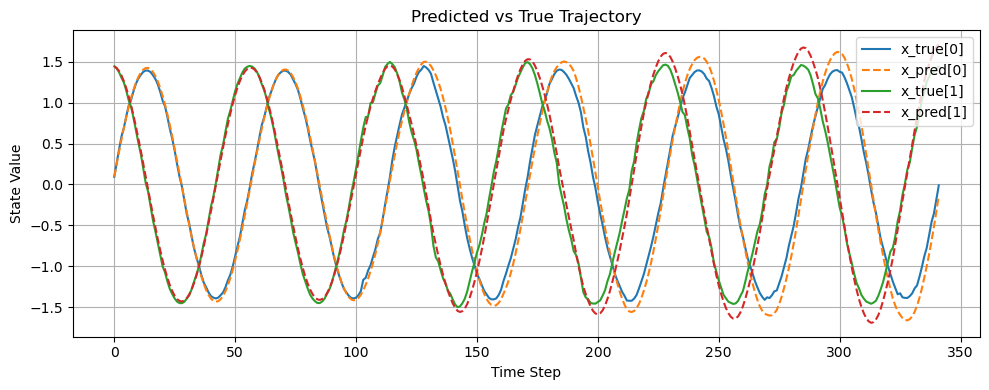

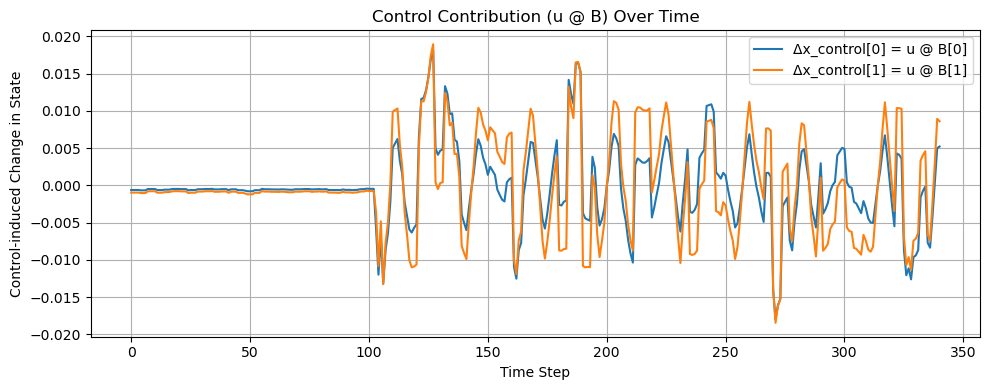

📌 Sample 34 - Class 5
MSE between predicted and true trajectory: 0.753673767483052


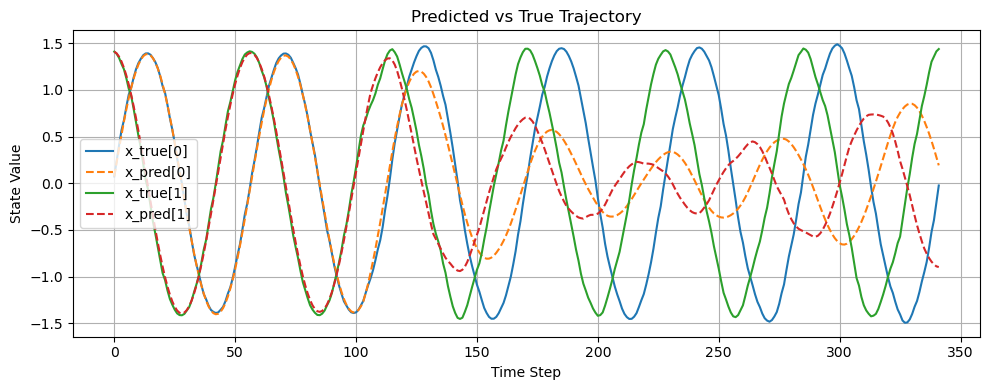

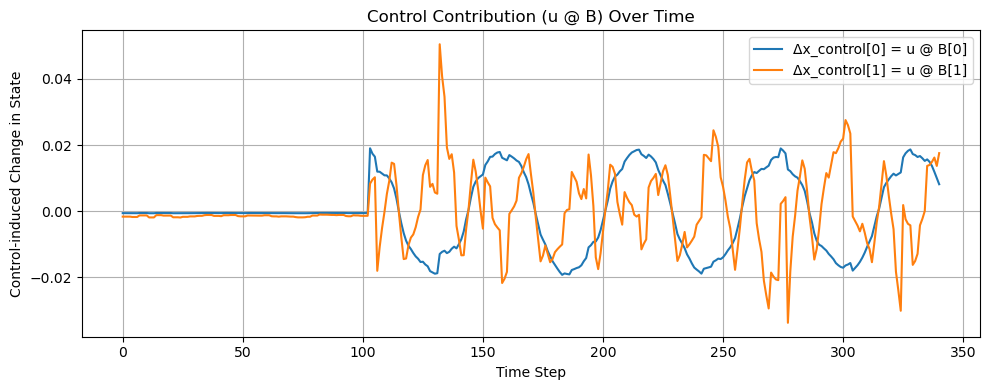

📌 Sample 19 - Class 2
MSE between predicted and true trajectory: 0.02814563047642526


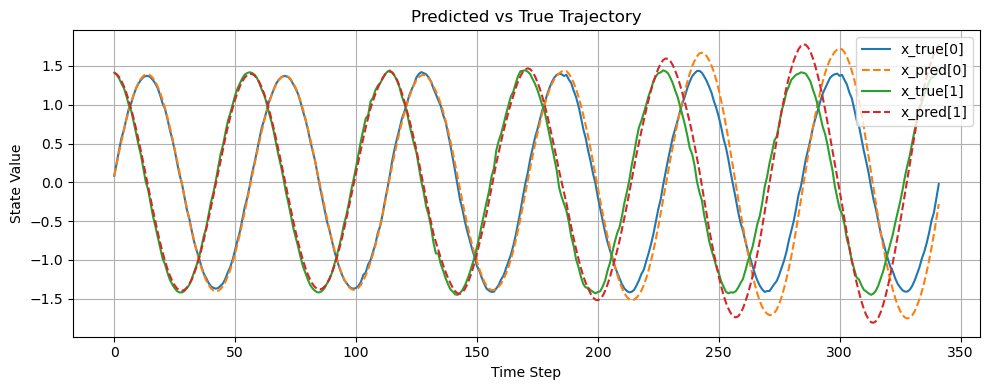

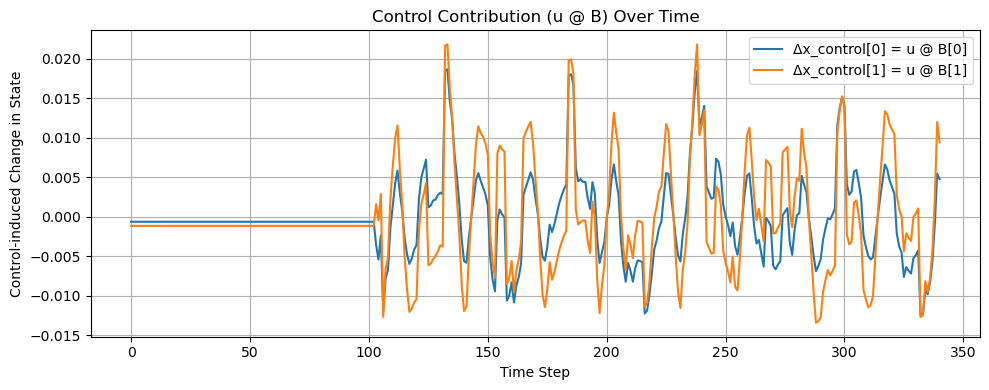

📌 Sample 74 - Class 5
MSE between predicted and true trajectory: 0.608556485229431


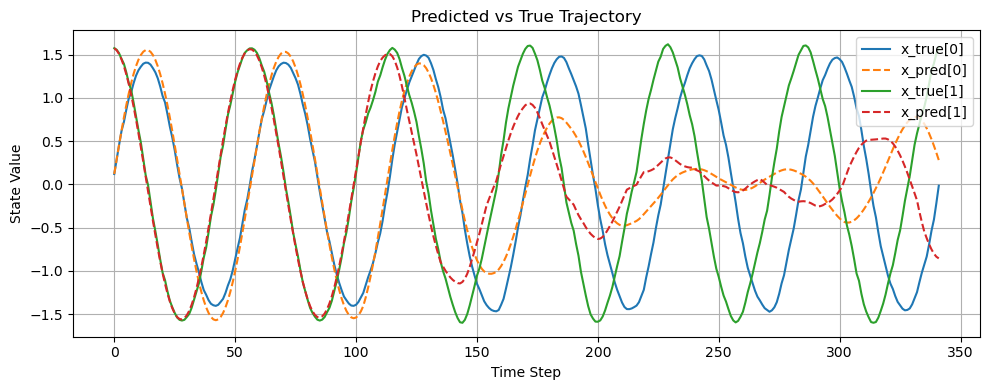

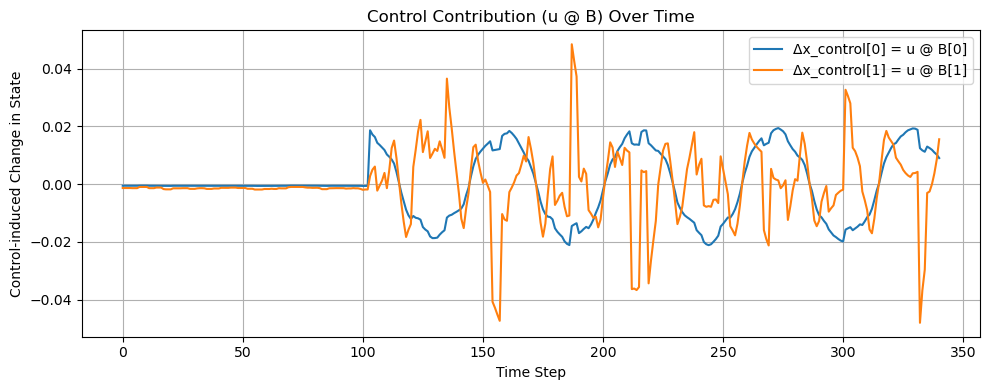

📌 Sample 12 - Class 0
MSE between predicted and true trajectory: 0.0035313125991379727


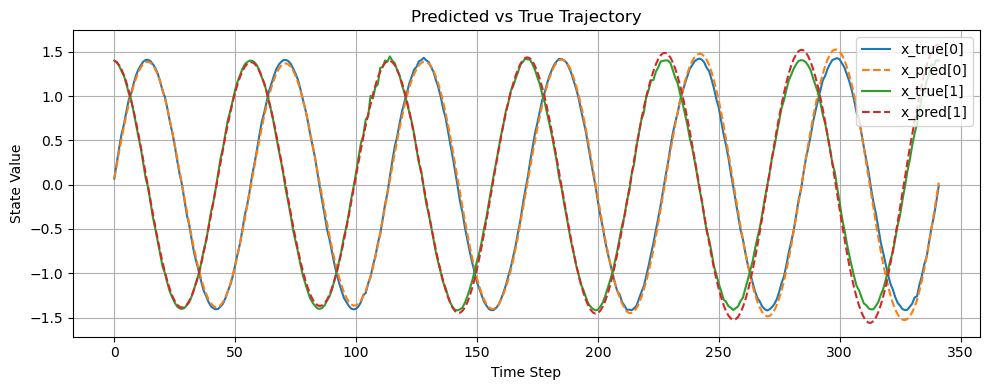

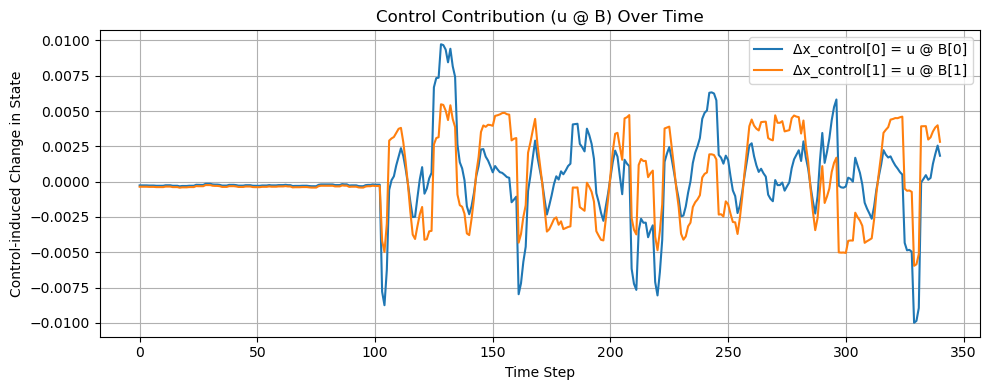

In [42]:
plot_random_trajectory_predictions(
    x_dataset=x_train,
    u_dataset=u_train,
    et_dataset=et_train,
    K_list=K_list_class,
    B_list=B_list_class,
    predict_fn=predict_trajectory,
    n_plot=5  # 可自由调整想画几个
)


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_mse_per_class(all_mse, et_dataset, title="Average MSE per Class"):
    """
    Plot average MSE per class using a bar chart.

    Args:
        all_mse (list of float): MSE values for each sample
        et_dataset (list): Contains one-hot class label at et_data[0]
        title (str): Plot title
    """
    # Step 1: 按类别收集 MSE
    class_mse = defaultdict(list)
    for i, et_data in enumerate(et_dataset):
        class_idx = int(np.argmax(et_data[0]))
        class_mse[class_idx].append(all_mse[i])

    # Step 2: 计算每类平均 MSE
    class_ids = sorted(class_mse.keys())
    avg_mse_per_class = [np.mean(class_mse[c]) for c in class_ids]

    # Step 3: 画图
    plt.figure(figsize=(8, 5))
    bars = plt.bar(class_ids, avg_mse_per_class, color='skyblue')
    plt.xticks(class_ids)
    plt.xlabel("Class")
    plt.ylabel("Average MSE")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # 在柱子上标数值
    for bar, mse in zip(bars, avg_mse_per_class):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f"{mse:.4f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    return dict(zip(class_ids, avg_mse_per_class))


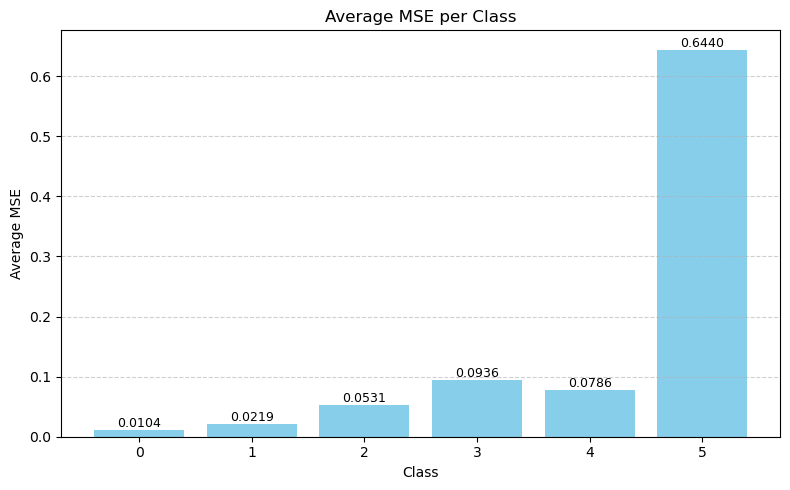

{0: np.float64(0.010406967627423946),
 1: np.float64(0.02185054566648485),
 2: np.float64(0.05311268259318363),
 3: np.float64(0.09358925897397238),
 4: np.float64(0.07857459778017269),
 5: np.float64(0.6440082734551271)}

In [44]:
plot_mse_per_class(all_mse, et_train, title="Average MSE per Class")

In [45]:
def evaluate_B_fit_with_true_u(x_data, u_data, et_data, K_list, B_list):
    """
    Evaluate each B_i using known u_data, and compare predicted best B to ground-truth class.

    Args:
        x_data (np.ndarray): shape (T, n_x)
        u_data (np.ndarray): shape (T, n_u)
        et_data (np.ndarray): one-hot label
        K (np.ndarray): system matrix
        B_list (list of np.ndarray): each (n_x, n_u)

    Returns:
        best_idx: predicted best B index
        true_idx: true label index from et_data
        mse_list: MSE for each B_i
        sorted_idx: indices sorted by MSE
        avg_label_order: average order of true labels in prediction
    """
    X_prev = x_data[:-1]
    X_next = x_data[1:]
    U = u_data[:-1]

    mse_list = []

    for K, B in zip(K_list, B_list):
        pred = X_prev @ K + U @ B.T
        mse = np.mean((X_next - pred) ** 2)
        mse_list.append(mse)

    # Get the indices sorted by MSE
    sorted_idx = np.argsort(mse_list)
    
    # Calculate the average order of true labels in the sorted list
    true_idx = np.argmax(et_data[0])  # Using np.argmax for one-hot encoding
    
    # Find the position of the true label in the sorted list (based on MSE)
    avg_label_order = np.where(sorted_idx == true_idx)[0][0] if true_idx in sorted_idx else -1
    
    best_idx = int(np.argmin(mse_list))  # Index of best B (with minimum MSE)
    
    return best_idx, true_idx, mse_list, sorted_idx, avg_label_order


In [46]:
def evaluate_B_selection_accuracy(x_dataset, u_dataset, et_dataset, K_list, B_list):
    """
    For each x_data, predict the best B_i index and compare to true class from et_dataset.
    Return accuracy across all samples.

    Args:
        x_dataset (list of np.ndarray): each (T, n_x)
        et_dataset (list): each et_data[0] is one-hot vector
        K_list (list of np.ndarray): list of system matrices
        B_list (list of np.ndarray): candidate B matrices

    Returns:
        accuracy (float): proportion of correctly predicted class
        predictions (list of int): predicted class index per sample
        ground_truth (list of int): true class index per sample
        sorted_predictions (list of list of int): sorted B indices per sample based on MSE
        avg_label_order (float): average order of labels across all samples
    """
    correct = 0
    predictions = []
    ground_truth = []
    sorted_predictions = []
    total_avg_label_order = 0
    label_order = []

    for x_data, u_data, et_data in zip(x_dataset, u_dataset, et_dataset):
        pred_idx, _, _, sorted_idx, avg_label_order = evaluate_B_fit_with_true_u(x_data, u_data, et_data, K_list, B_list)
        true_idx = int(np.argmax(et_data[0]))

        predictions.append(pred_idx)
        ground_truth.append(true_idx)
        sorted_predictions.append(sorted_idx)
        total_avg_label_order += avg_label_order
        label_order.append(avg_label_order)

        if pred_idx == true_idx:
            correct += 1

    accuracy = correct / len(x_dataset)
    avg_label_order = total_avg_label_order / len(x_dataset)

    print(f"✅ Accuracy: {accuracy * 100:.2f}% ({correct}/{len(x_dataset)})")
    print(f"✅ Average label order: {avg_label_order:.2f}")
    
    return accuracy, predictions, ground_truth, label_order, avg_label_order


In [47]:
accuracy_train, predictions_train, ground_truth_train, sorted_predictions_train, avg_label_order_train = evaluate_B_selection_accuracy(
    x_train, u_train, et_train, K_list_class, B_list_class
)

✅ Accuracy: 84.38% (81/96)
✅ Average label order: 0.30


In [48]:
accuracy_test, predictions_test, ground_truth_test, sorted_predictions_test, avg_label_order_test = evaluate_B_selection_accuracy(x_test, u_test, et_test, K_list_class, B_list_class)

✅ Accuracy: 75.00% (18/24)
✅ Average label order: 0.33


In [49]:
# for pred, true in zip(predictions_test, ground_truth_test):
#     print(pred == true)

In [50]:
print(predictions_test)

[3, 5, 5, 4, 0, 2, 0, 5, 5, 4, 4, 4, 3, 4, 0, 2, 5, 1, 3, 2, 0, 4, 4, 2]


In [51]:
print(ground_truth_test)

[1, 5, 5, 4, 0, 3, 0, 5, 5, 4, 4, 4, 3, 4, 0, 2, 5, 2, 3, 3, 0, 4, 3, 3]


In [52]:
def evaluate_B_selection_accuracy_em(x_dataset, et_dataset, K_list, B_list, n_u, max_iters=100):
    """
    For each x_data, iteratively predict the best B_i index when u_data is unknown.
    This is achieved using an EM-like algorithm where we iteratively estimate u_data and select B.

    Args:
        x_dataset (list of np.ndarray): each (T, n_x)
        et_dataset (list): each et_data[0] is one-hot vector
        K_list (list of np.ndarray): shared system matrices
        B_list (list of np.ndarray): candidate B matrices
        n_u (int): number of input features
        max_iters (int): maximum number of iterations for EM algorithm

    Returns:
        accuracy (float): proportion of correctly predicted class
        predictions (list of int): predicted class index per sample
        ground_truth (list of int): true class index per sample
    """
    correct = 0
    predictions = []
    ground_truth = []

    for x_data, et_data in zip(x_dataset, et_dataset):
        # Initialize u_data estimate (shape should be (T-1, n_u))
        u_data_estimate = np.zeros((x_data.shape[0] - 1, n_u))  # (T-1, n_u)
        
        # EM algorithm iterations
        for _ in range(max_iters):
            # E-step: Estimate u_data based on current B_list and K_list
            for i, (K, B) in enumerate(zip(K_list, B_list)):
                # Predict the next state using the current estimate of u_data
                X_prev = x_data[:-1]  # Shape: (T-1, n_x)
                X_next = x_data[1:]   # Shape: (T-1, n_x)
                # Estimate u_data based on the system model and current estimate of B
                u_data_estimate = np.linalg.pinv(B.T) @ (X_next - X_prev @ K).T  # Shape: (T-1, n_u)
                u_data_estimate = u_data_estimate.T

            
            # M-step: Select the best B (minimize the error)
            pred_idx, _ = evaluate_B_fit_with_estimated_u(x_data, u_data_estimate, K_list, B_list)
        
        true_idx = int(np.argmax(et_data[0]))
        predictions.append(pred_idx)
        ground_truth.append(true_idx)

        if pred_idx == true_idx:
            correct += 1

    accuracy = correct / len(x_dataset)
    print(f"✅ Accuracy: {accuracy * 100:.2f}% ({correct}/{len(x_dataset)})")
    return accuracy, predictions, ground_truth

def evaluate_B_fit_with_estimated_u(x_data, u_data_estimate, K_list, B_list):
    """
    Evaluate each B_i using estimated u_data, and compare predicted best B to ground-truth class.

    Args:
        x_data (np.ndarray): shape (T, n_x)
        u_data_estimate (np.ndarray): shape (T-1, n_u)
        K_list (list of np.ndarray): shared system matrices
        B_list (list of np.ndarray): candidate B matrices

    Returns:
        best_idx: predicted best B index
        mse_list: MSE for each B_i
    """
    X_prev = x_data[:-1]  # Shape: (T-1, n_x)
    X_next = x_data[1:]   # Shape: (T-1, n_x)
    U_estimate = u_data_estimate  # Shape: (T-1, n_u)

    mse_list = []

    for K, B in zip(K_list, B_list):
        # Predict the next state using the current estimate of u_data
        pred = X_prev @ K + U_estimate @ B.T
        mse = np.mean((X_next - pred) ** 2)
        mse_list.append(mse)

    best_idx = int(np.argmin(mse_list))
    return best_idx, mse_list


In [53]:
accuracy_train_em, predictions_train_em, ground_truth_train_em =  evaluate_B_selection_accuracy_em(
    x_train, et_train, K_list_class, B_list_class, 2, max_iters=100
)

✅ Accuracy: 16.67% (16/96)


In [54]:
x_train_cut = [x[100:, :] for x in x_train]
K_list_class, B_list_class, B_mse_list = compute_K_and_B_per_class(x_train_cut, x_train_cut, et_train, shared_K=True)

print("K =", K_list_class)
print("B_list contains", len(B_list), "class-specific B matrices.")
print("B_mse_list =", B_mse_list)


K = [array([[ 0.99310189, -0.1091915 ],
       [ 0.11037884,  0.99452307]]), array([[ 0.99310189, -0.1091915 ],
       [ 0.11037884,  0.99452307]]), array([[ 0.99310189, -0.1091915 ],
       [ 0.11037884,  0.99452307]]), array([[ 0.99310189, -0.1091915 ],
       [ 0.11037884,  0.99452307]]), array([[ 0.99310189, -0.1091915 ],
       [ 0.11037884,  0.99452307]]), array([[ 0.99310189, -0.1091915 ],
       [ 0.11037884,  0.99452307]])]
B_list contains 96 class-specific B matrices.
B_mse_list = [np.float64(0.0004879483887652469), np.float64(0.0006325186412327199), np.float64(0.000699790802827999), np.float64(0.0007420899879636664), np.float64(0.0006572792756174869), np.float64(0.0005070348676419281)]


In [55]:
all_mse, avg_mse = evaluate_all_trajectories(
    x_dataset=x_train,
    u_dataset=x_train,
    et_dataset=et_train,
    K_list=K_list_class,
    B_list=B_list_class,
    predict_fn=predict_trajectory
)

MSE between predicted and true trajectory: 0.002224894406612298
MSE between predicted and true trajectory: 0.006497834842296295
MSE between predicted and true trajectory: 0.0019033923370873678
MSE between predicted and true trajectory: 0.00835520752086117
MSE between predicted and true trajectory: 0.005156032906827147
MSE between predicted and true trajectory: 0.03226691555236318
MSE between predicted and true trajectory: 0.005532802895146671
MSE between predicted and true trajectory: 0.0038968749643785803
MSE between predicted and true trajectory: 0.006936828134900572
MSE between predicted and true trajectory: 0.006694642342574265
MSE between predicted and true trajectory: 0.008790293069036165
MSE between predicted and true trajectory: 0.0019153987377041155
MSE between predicted and true trajectory: 0.0023889909638506552
MSE between predicted and true trajectory: 0.005243521731015856
MSE between predicted and true trajectory: 0.0023522264439145906
MSE between predicted and true trajec

📌 Sample 1 - Class 5
MSE between predicted and true trajectory: 0.006497834842296295


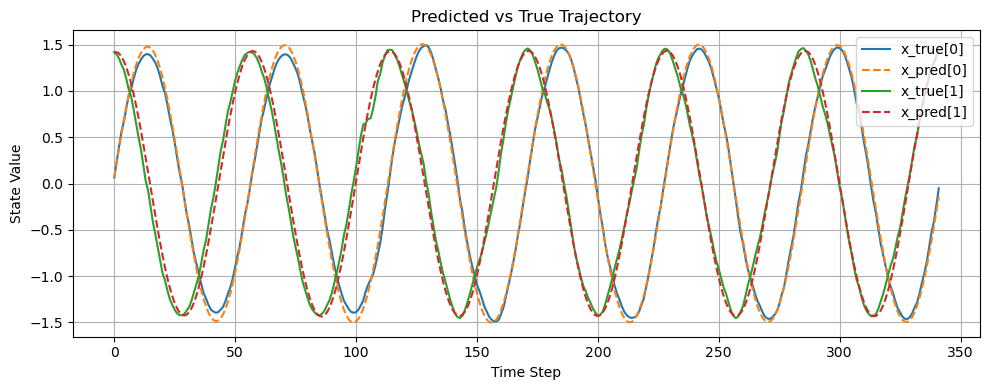

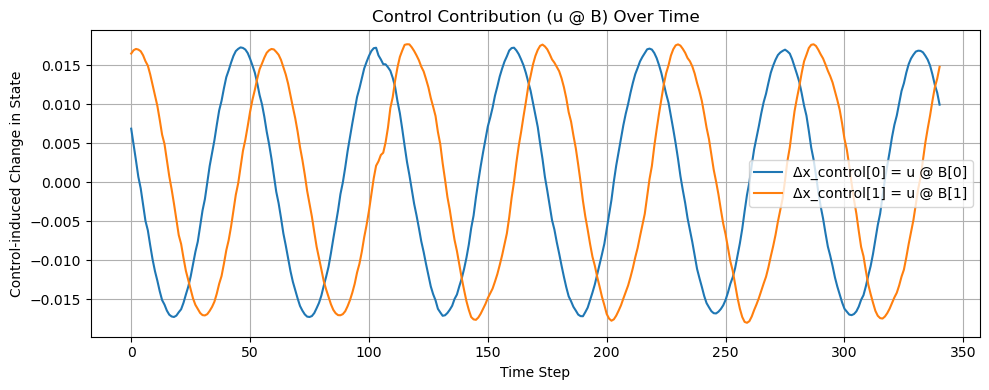

📌 Sample 66 - Class 1
MSE between predicted and true trajectory: 0.00472360134879422


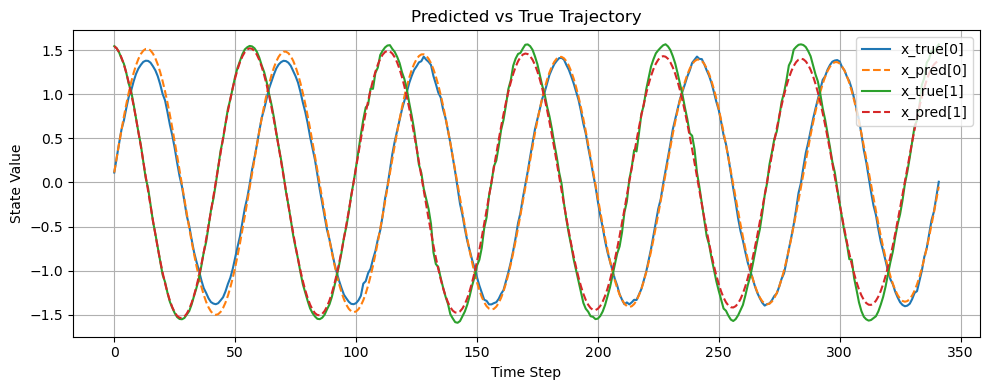

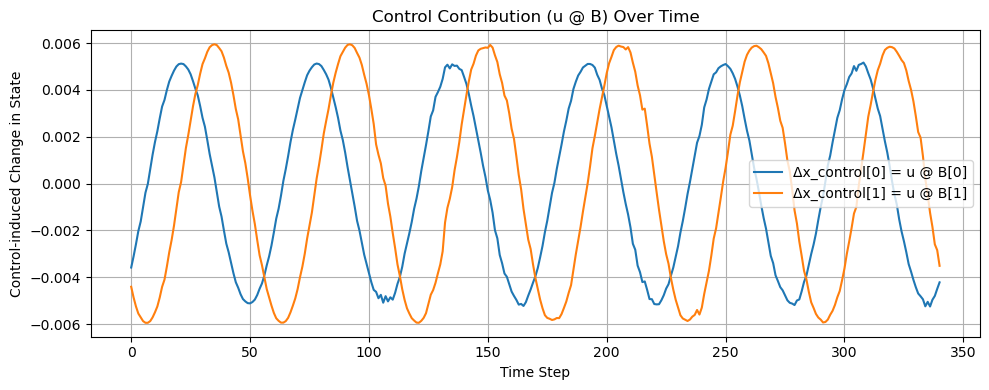

📌 Sample 13 - Class 3
MSE between predicted and true trajectory: 0.005243521731015856


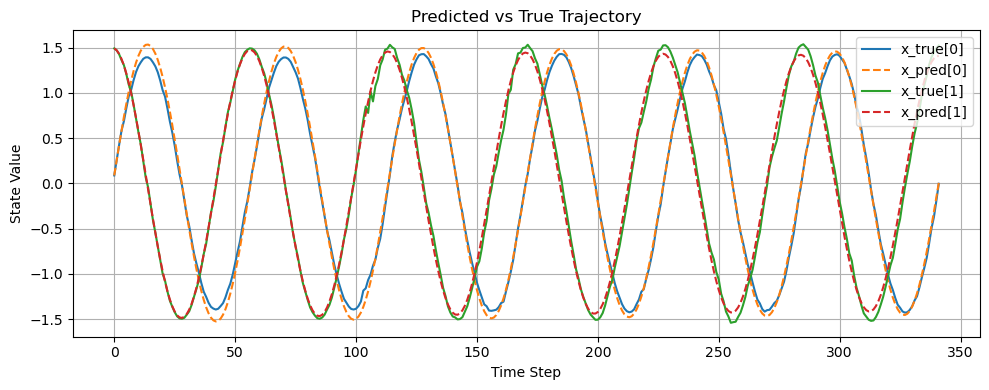

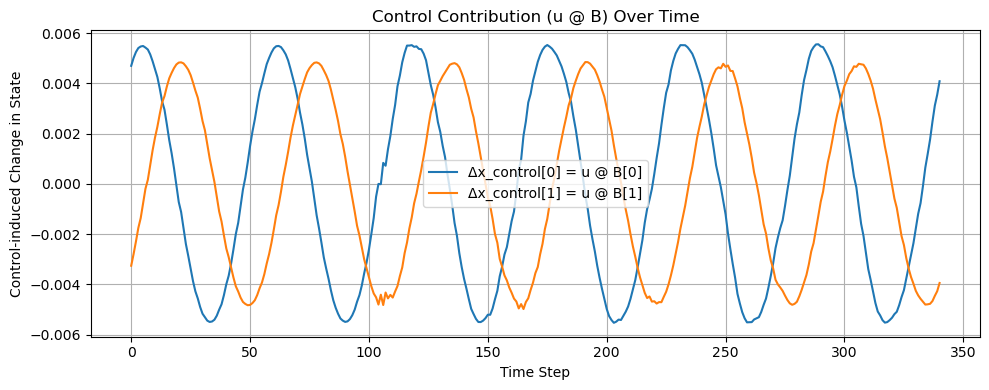

📌 Sample 35 - Class 5
MSE between predicted and true trajectory: 0.008090110402209529


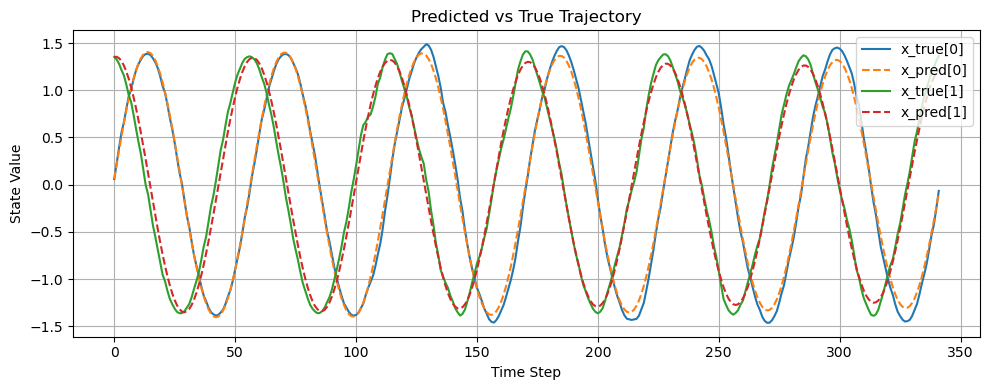

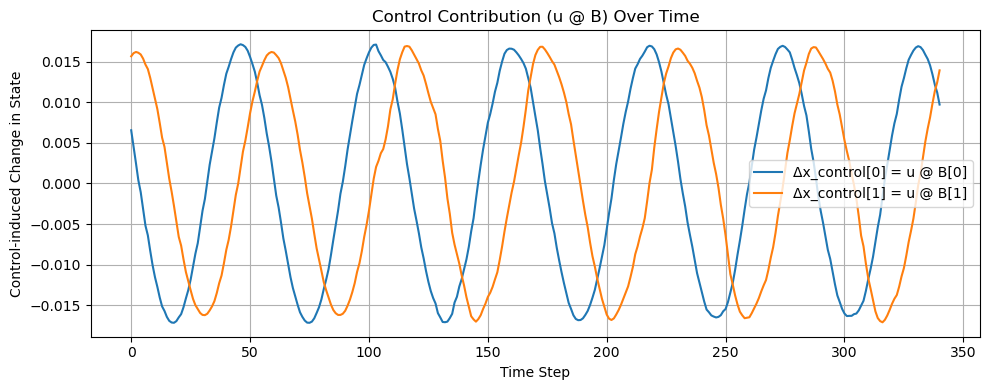

📌 Sample 92 - Class 1
MSE between predicted and true trajectory: 0.002330490786579858


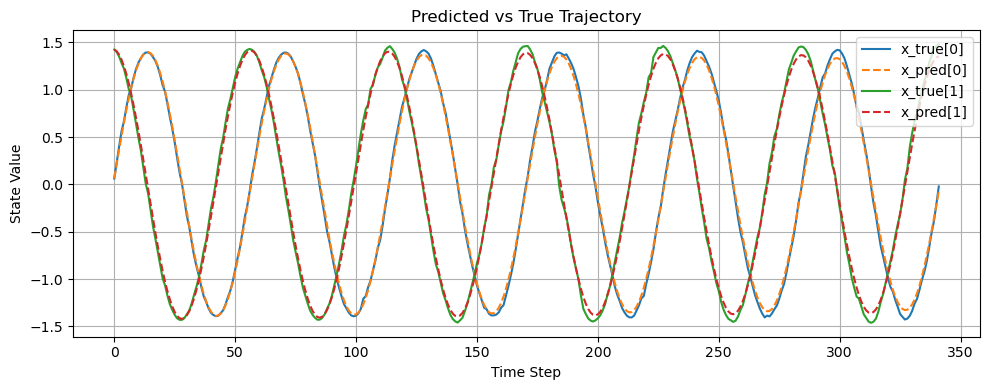

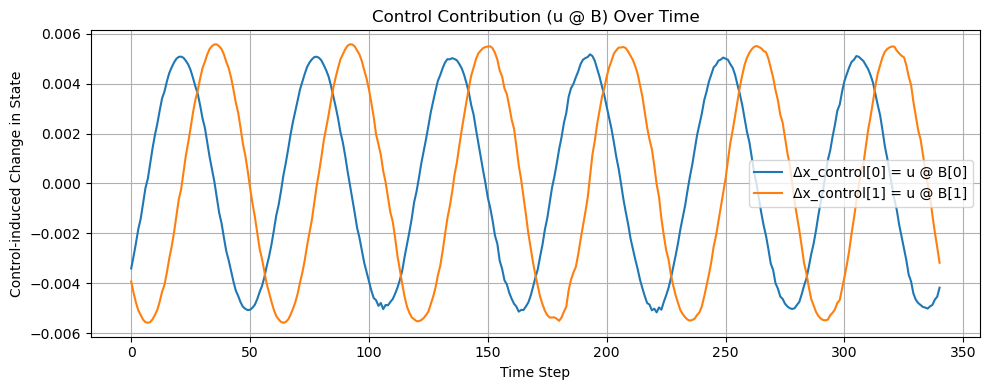

In [56]:
plot_random_trajectory_predictions(
    x_dataset=x_train,
    u_dataset=x_train,
    et_dataset=et_train,
    K_list=K_list_class,
    B_list=B_list_class,
    predict_fn=predict_trajectory,
    n_plot=5  # 可自由调整想画几个
)


In [57]:
accuracy_train_x, predictions_train_x, ground_truth_train_x, sorted_predictions_train_x, avg_label_order_train_x= evaluate_B_selection_accuracy(
    x_train_cut, x_train_cut, et_train, K_list_class, B_list_class
)

✅ Accuracy: 54.17% (52/96)
✅ Average label order: 0.82


In [58]:
x_test_cut = [x[100:, :] for x in x_test]
accuracy_test_x, predictions_test_x, ground_truth_test_x, sorted_predictions_test_x, avg_label_order_test_x = evaluate_B_selection_accuracy(x_test_cut, x_test_cut, et_test, K_list_class, B_list_class)


✅ Accuracy: 62.50% (15/24)
✅ Average label order: 0.46


In [59]:
sorted_predictions_test

[np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(3),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1)]

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cumulative_predictions_histogram(sorted_predictions, L=6, I=None, title="Cumulative Class Index Distribution"):
    """
    Plot the cumulative histogram (cumulative sum) of class indices across all samples,
    and annotate each bar with its value and percentage.

    Args:
        sorted_predictions (list of list of int or list of int64): sorted B indices per sample based on MSE
        L (int): total number of classes (e.g., 6 classes => indices 0 to 5)
        I (int or None): number of classes to display (must be <= L); if None, display all L classes.
        title (str): plot title
    """
    # Flatten the list of sorted predictions into a single list
    all_predictions = []
    for sublist in sorted_predictions:
        if isinstance(sublist, list):
            all_predictions.extend([int(item) for item in sublist])
        else:
            all_predictions.append(int(sublist))
    
    # Count occurrences of each class index (0 to L-1)
    class_counts = [0] * L
    for pred in all_predictions:
        if 0 <= pred < L:
            class_counts[pred] += 1

    # Compute cumulative sum
    cumulative_counts = np.cumsum(class_counts)

    # How many classes to plot
    plot_classes = I if I is not None else L
    total_samples = sum(class_counts)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(1, plot_classes+1), cumulative_counts[:plot_classes], edgecolor='black', alpha=0.7)

    # Annotate each bar with value and percentage
    for idx, bar in enumerate(bars):
        value = cumulative_counts[idx]
        percentage = 100.0 * value / total_samples if total_samples > 0 else 0.0
        plt.text(bar.get_x() + bar.get_width() / 2, 
                 bar.get_height(), 
                 f'{value}\n({percentage:.2f}%)',
                 ha='center', va='bottom', fontsize=11)

    plt.xlabel("Class Index")
    plt.ylabel("Cumulative Frequency")
    plt.title(title)
    plt.xticks(range(1, plot_classes+1))
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


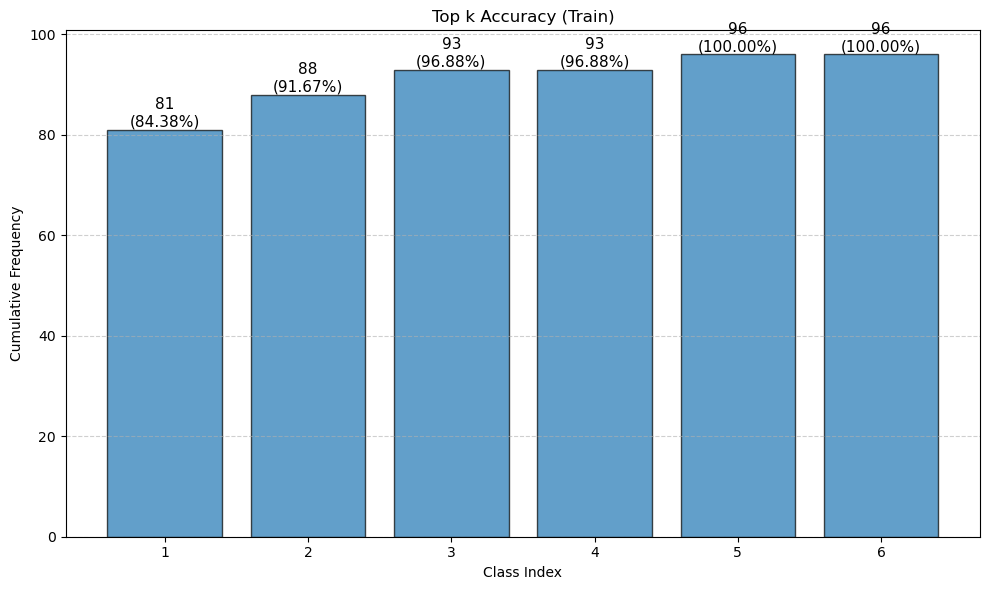

In [77]:
plot_cumulative_predictions_histogram(sorted_predictions_train, L=6, title="Top k Accuracy (Train)")

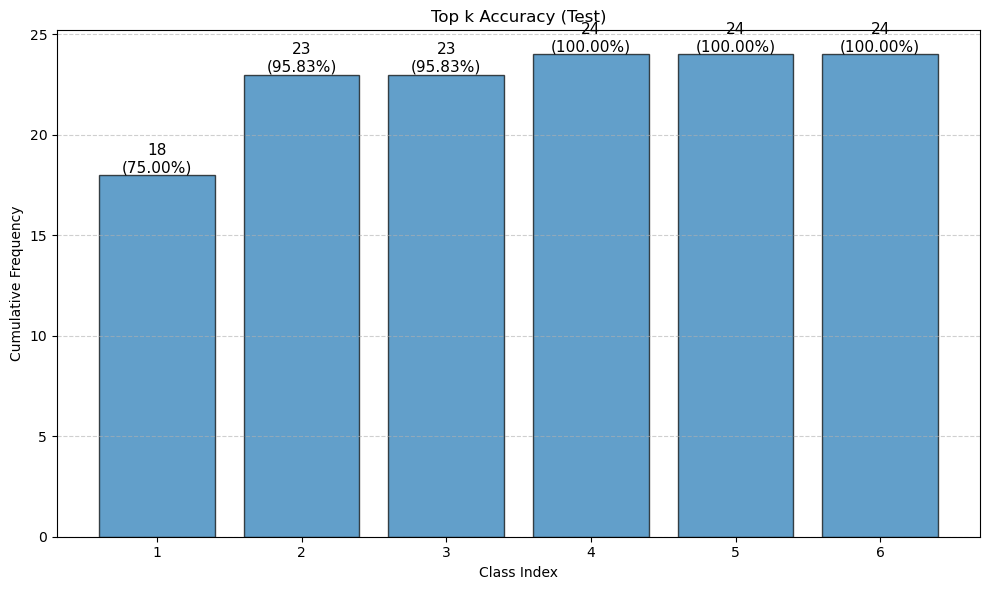

In [78]:
plot_cumulative_predictions_histogram(sorted_predictions_test, L=6, title="Top k Accuracy (Test)")

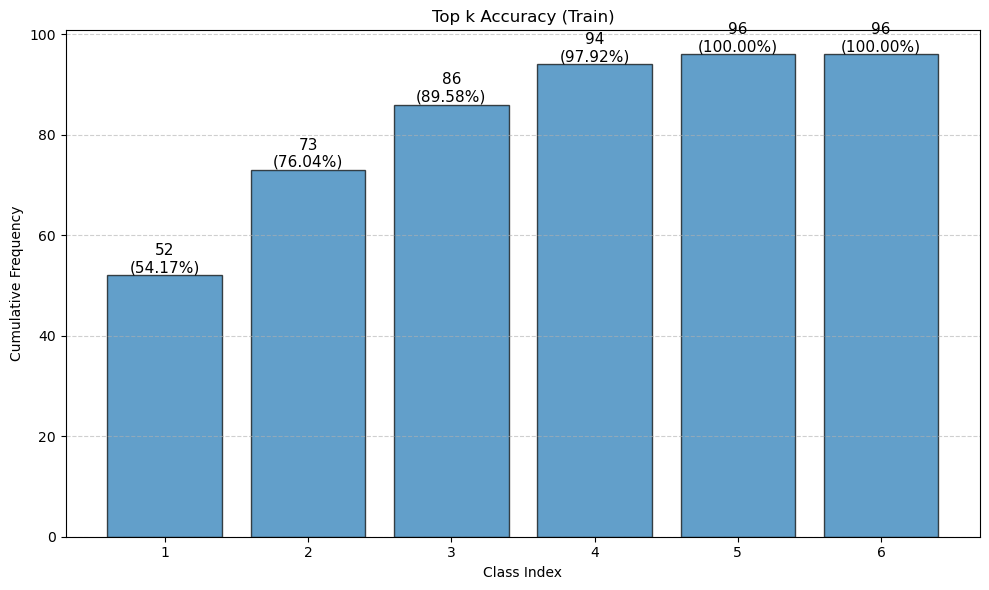

In [79]:
plot_cumulative_predictions_histogram(sorted_predictions_train_x, L=6, title="Top k Accuracy (Train)")

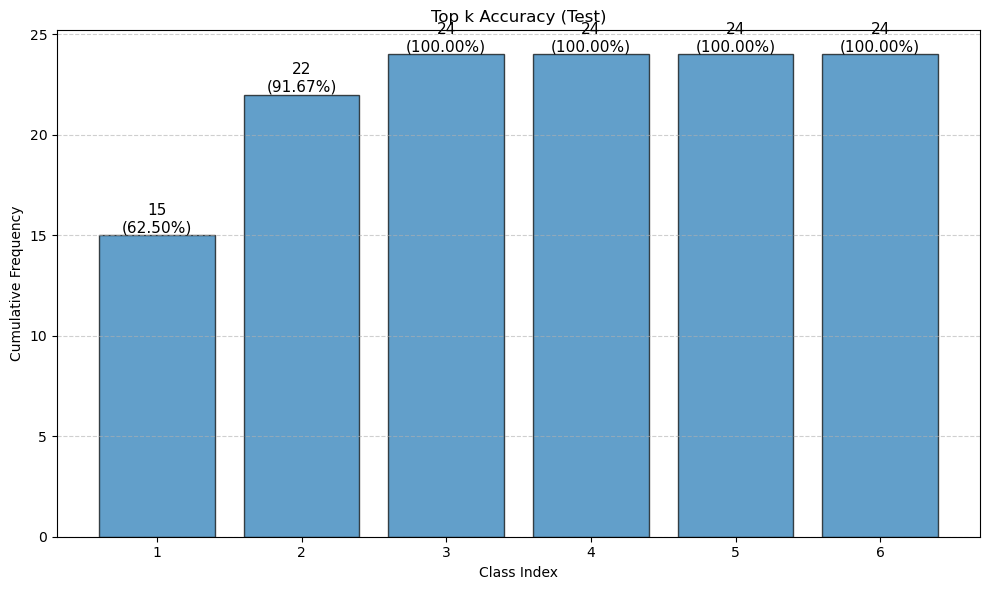

In [80]:
plot_cumulative_predictions_histogram(sorted_predictions_test_x, L=6, title="Top k Accuracy (Test)")


In [81]:
def calculate_top_k_accuracy(sorted_predictions, ground_truth, k=1):
    """
    Calculate the top-k accuracy based on sorted predictions and ground truth.

    Args:
        sorted_predictions (list of list of int): sorted B indices per sample based on MSE
        ground_truth (list of int): true class index per sample
        k (int): top-k accuracy to calculate

    Returns:
        top_k_accuracy (float): proportion of samples where the true class is in the top-k predictions
    """
    correct = 0
    total_samples = len(sorted_predictions)

    for i, preds in enumerate(sorted_predictions):
        if ground_truth[i] in preds[:k]:
            correct += 1

    top_k_accuracy = correct / total_samples if total_samples > 0 else 0.0
    return top_k_accuracy